# Visualise metrics and results V2

Load saved dicts containing metrics (puffs and waves IoUs, sparks precision and recall) and visualize them in order to understan the behaviour of the network.

Dicts are saved in folders `training_validation\<training name>\<metrics type>`, where "metrics type" can be
- `puff_wave_metrics`
- `spark_prec_rec`
- `separated_events`
- ... (work in progress)

**REMARKS:** 
- Same as `visualise metrics and results.ipynb`, but with updated metrics (precision, recall, pixel accuracy for puffs and waves in addition to IoU).
- When done: delete previous version of file

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import imageio
from collections import defaultdict
import pprint
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
import seaborn as sns

from metrics_tools import compute_f_score

In [3]:
BASEDIR = os.path.abspath('')
BASEDIR

'C:\\Users\\dotti\\sparks_project\\sparks'

### Set training params

- UNet has been trained for 100K epochs (how to justify this in manuscript?) using focal loss, where `alpha = class_weights` and `gamma = 5`, and `batch_size = 1`.
- Average background has been subtracted from whole videos (tried "moving average" but didn't improve results: what is the best approach?).
- Chunks have `duration = 256` and `step = 32`, 6 frames are ignored by loss in each chunk. Each chunk is normalised to have values between 0 and 1.
- The only preprocessing is a 2d Gaussian smoothing.
- Tried to train network using temporal reduction but it didn't improve the results.

In [4]:
training_name = "focal_loss_gamma_5_ubelix"
ignore_frames = 6 # first and last 6 frames not used for computing metrics

In [5]:
metrics_folder = os.path.join("trainings_validation", "train_samples", training_name)

# Puffs and waves metrics
- Considering IoU, pixel accuracy, precision and recall
- Considering varying minimal size of events and detection threshold
- Removing holes from puffs, where sparks have a higher probability
- Regarding IoU:
    - Using exclusion radius (erosion & dilation applied to annotations)
- Tried computing IoU score for joined puffs and waves, TODO: compute other combinations of classes

### Load pre-computed metrics

In [6]:
data_folder = os.path.join(metrics_folder, "puff_wave_metrics")

# Load dicts
# Metrics are metrics = {iou, prec, rec, accuracy}

# dict containing all metrics scores for all puffs for all movies
with open(os.path.join(data_folder, "metrics_puffs.json"), 'r') as f:
    metrics_puffs = json.load(f) # t x min_r x exclusion_r x video_id x metrics
    
# dict containing all metrics scores for all puffs averaged over all movies
with open(os.path.join(data_folder, "metrics_puffs_average.json"), 'r') as f:
    metrics_puffs_average = json.load(f) # t x min_r x exclusion_r x metrics
    
# dict containing all metrics scores for all puffs without holes for all movies
with open(os.path.join(data_folder, "metrics_puffs_no_holes.json"), 'r') as f:
    metrics_puffs_no_holes = json.load(f) # t x min_r x video_id x metrics
    
# dict containing all metrics scores for all puffs without holes averaged over all movies
with open(os.path.join(data_folder, "metrics_puffs_no_holes_average.json"), 'r') as f:
    metrics_puffs_no_holes_average = json.load(f) # t x min_r x metrics
    
# dict containing all metrics scores for all waves for all movies
with open(os.path.join(data_folder, "metrics_waves.json"), 'r') as f:
    metrics_waves = json.load(f) # t x min_r x exclusion_r x video_id x metrics
    
# dict containing all metrics scores for all waves averaged over all movies
with open(os.path.join(data_folder, "metrics_waves_average.json"), 'r') as f:
    metrics_waves_average = json.load(f) # t x min_r x exclusion_r x metrics
    
# dict containing all metrics scores for summed puffs and waves for all movies
with open(os.path.join(data_folder, "metrics_joined_puffs_waves.json"), 'r') as f:
    metrics_joined_puffs_waves = json.load(f) # t x min_r x exclusion_r x video_id x metrics
    
# dict containing all metrics scores for summed puffs and waves averaged over all movies
with open(os.path.join(data_folder, "metrics_joined_puffs_waves_average.json"), 'r') as f:
    metrics_joined_puffs_waves_average = json.load(f) # t x min_r x exclusion_r x metrics
    
# dict containing all metrics scores for summed puffs and sparks for all movies
with open(os.path.join(data_folder, "metrics_joined_puffs_sparks.json"), 'r') as f:
    metrics_joined_puffs_sparks = json.load(f) # t x min_r x exclusion_r x video_id x metrics
    
# dict containing all metrics scores for summed puffs and sparks averaged over all movies
with open(os.path.join(data_folder, "metrics_joined_puffs_sparks_average.json"), 'r') as f:
    metrics_joined_puffs_sparks_average = json.load(f) # t x min_r x exclusion_r x metrics
        
# dict containing all metrics scores for all classes summed for all movies
with open(os.path.join(data_folder, "metrics_joined_all_classes.json"), 'r') as f:
    metrics_joined_all_classes = json.load(f) # t x min_r x exclusion_r x video_id x metrics
    
# dict containing all metrics scores for all classes summed averaged over all movies
with open(os.path.join(data_folder, "metrics_joined_all_classes_average.json"), 'r') as f:
    metrics_joined_all_classes_average = json.load(f) # t x min_r x exclusion_r x metrics

## Puff metrics for all thresholds (IoU score, pixel accuracy, precision, recall)

- UNet's output processing:
    - threshold is applied to output
    - if required, remove holes with 5 iterations of dilation and erosion
    - remove small object with size < 2 * min_radius * n_dims (can be changed)
    - empty marginal frames (not used by loss function)
- Metrics computation:
    - compute true positive (tp), true negative (tn), false positive (fp) and false negative (fn) pixels
    - if exclusion radius > 0
        - compute annotations dilation, erosion and finally exclusion mask
        - compute intersection of tp, tn, fp, fn with exclusion mask
    - if using an ignore mask
        - compute dilation of ignore mask, if using the exclusion radius
        - compute intersection of tp, tn, fp, fn with (not) ignore mask
    - compute all metrics according to definition

### Get dicts containing puff metrics and visualise them, with exclusion_radius = 0

### Average over all movies

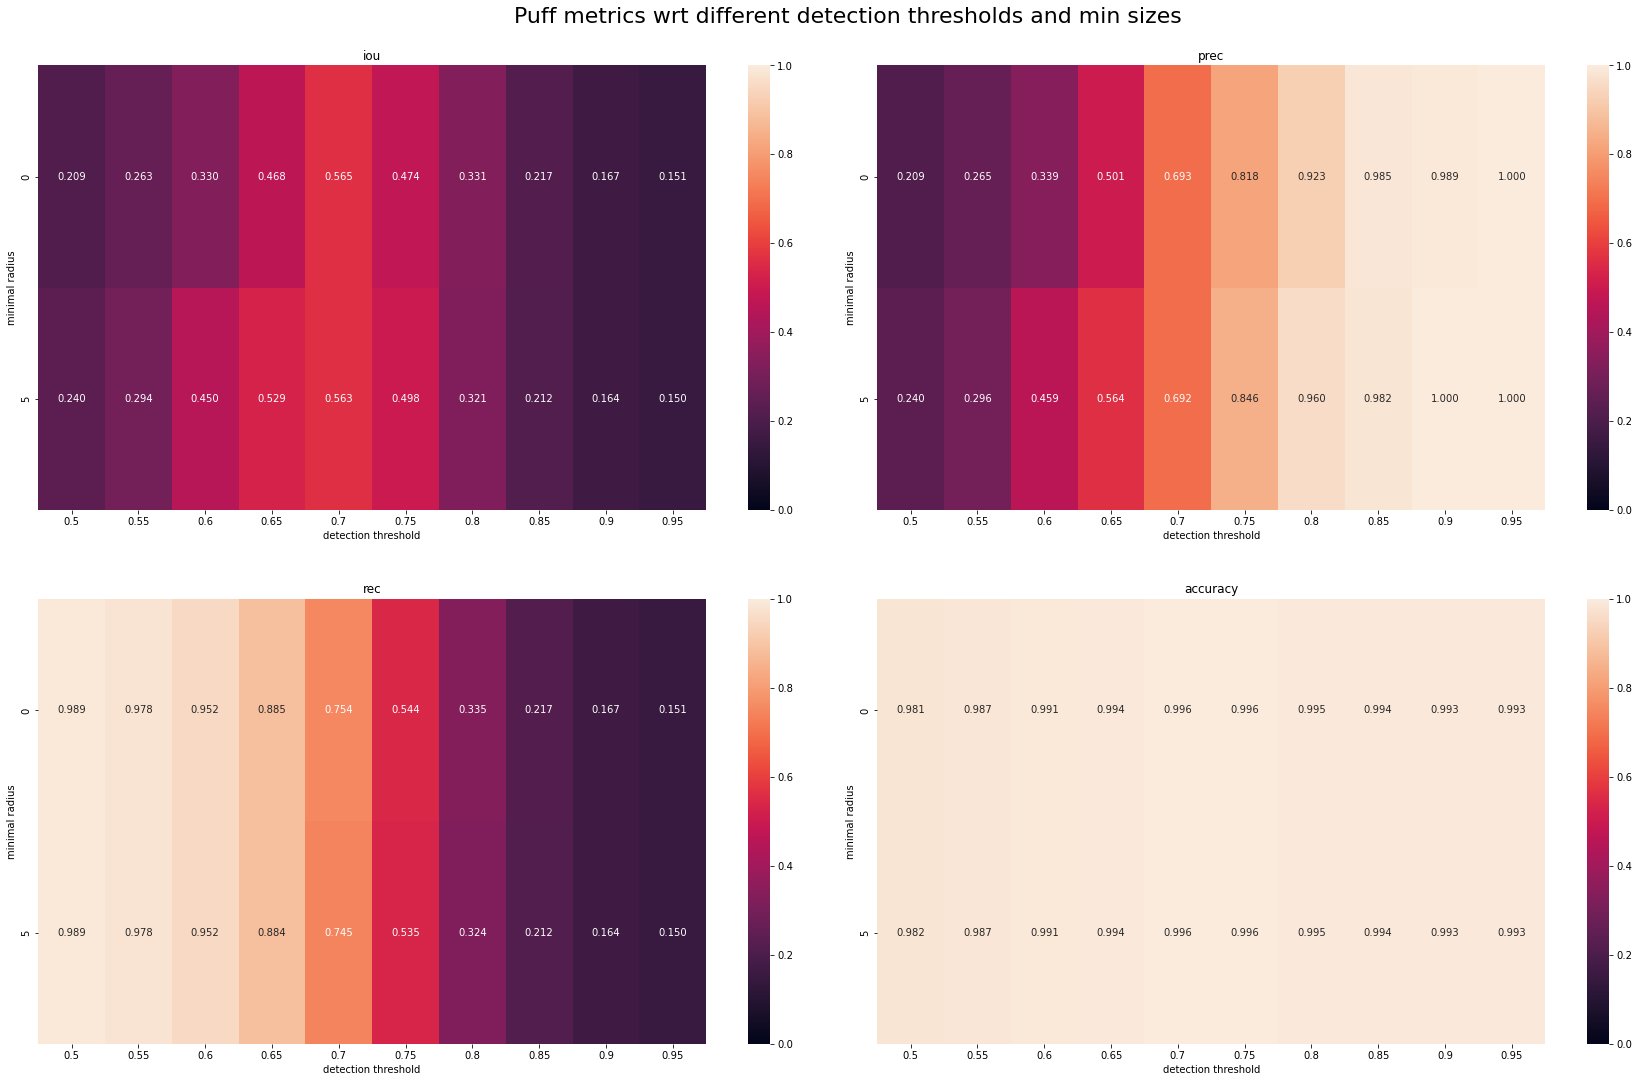

In [7]:
# fix exclusion radius to zero (for puffs without holes, metrics has been computed only for exclusion_r = 0)
exclusion_r = '0'

# get dicts for fixed exclusion radius (metric x t x min_r)
metrics_plot_dict = defaultdict(lambda: defaultdict(dict))
for t, min_r_metrics in metrics_puffs_average.items():
    for min_r, exclusion_r_metrics in min_r_metrics.items():
        for metric, val in exclusion_r_metrics[exclusion_r].items():
            metrics_plot_dict[metric][round(float(t),2)][min_r] = val

metrics_no_holes_plot_dict = defaultdict(lambda: defaultdict(dict))
for t, min_r_metrics in metrics_puffs_no_holes_average.items():
    for min_r, metrics in min_r_metrics.items():
        for metric, val in metrics.items():
            metrics_no_holes_plot_dict[metric][round(float(t),2)][min_r] = val
            
# visualise metrics for raw predicted puffs
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 18))
plt.subplots_adjust(hspace=0.2, wspace=0.005)
fig.suptitle(f"Puff metrics wrt different detection thresholds and min sizes", fontsize=22, y=0.925)

# loop through metrics and axes
for (metric, val_dict), ax in zip(metrics_plot_dict.items(), axs.ravel()):
    # val_dict is detection_t x min_r
    
    # get dataframes
    df = pd.DataFrame.from_dict(val_dict)
    df.to_csv(os.path.join(data_folder,"df_puffs_average_"+metric+".csv"))
    
    # plot metrics
    ax.set_title(metric)
    sns.heatmap(df, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
    ax.set_xlabel("detection threshold")
    ax.set_ylabel("minimal radius")
    
    #ax.get_legend().remove()

plt.savefig(os.path.join(data_folder,"puff_metrics_average_heatmaps.jpg"))
plt.show()

#### Removing holes --> NOT USEFUL
Many predicted puff masks have holes inside the events due to the fact that sparks can appear on top of them.

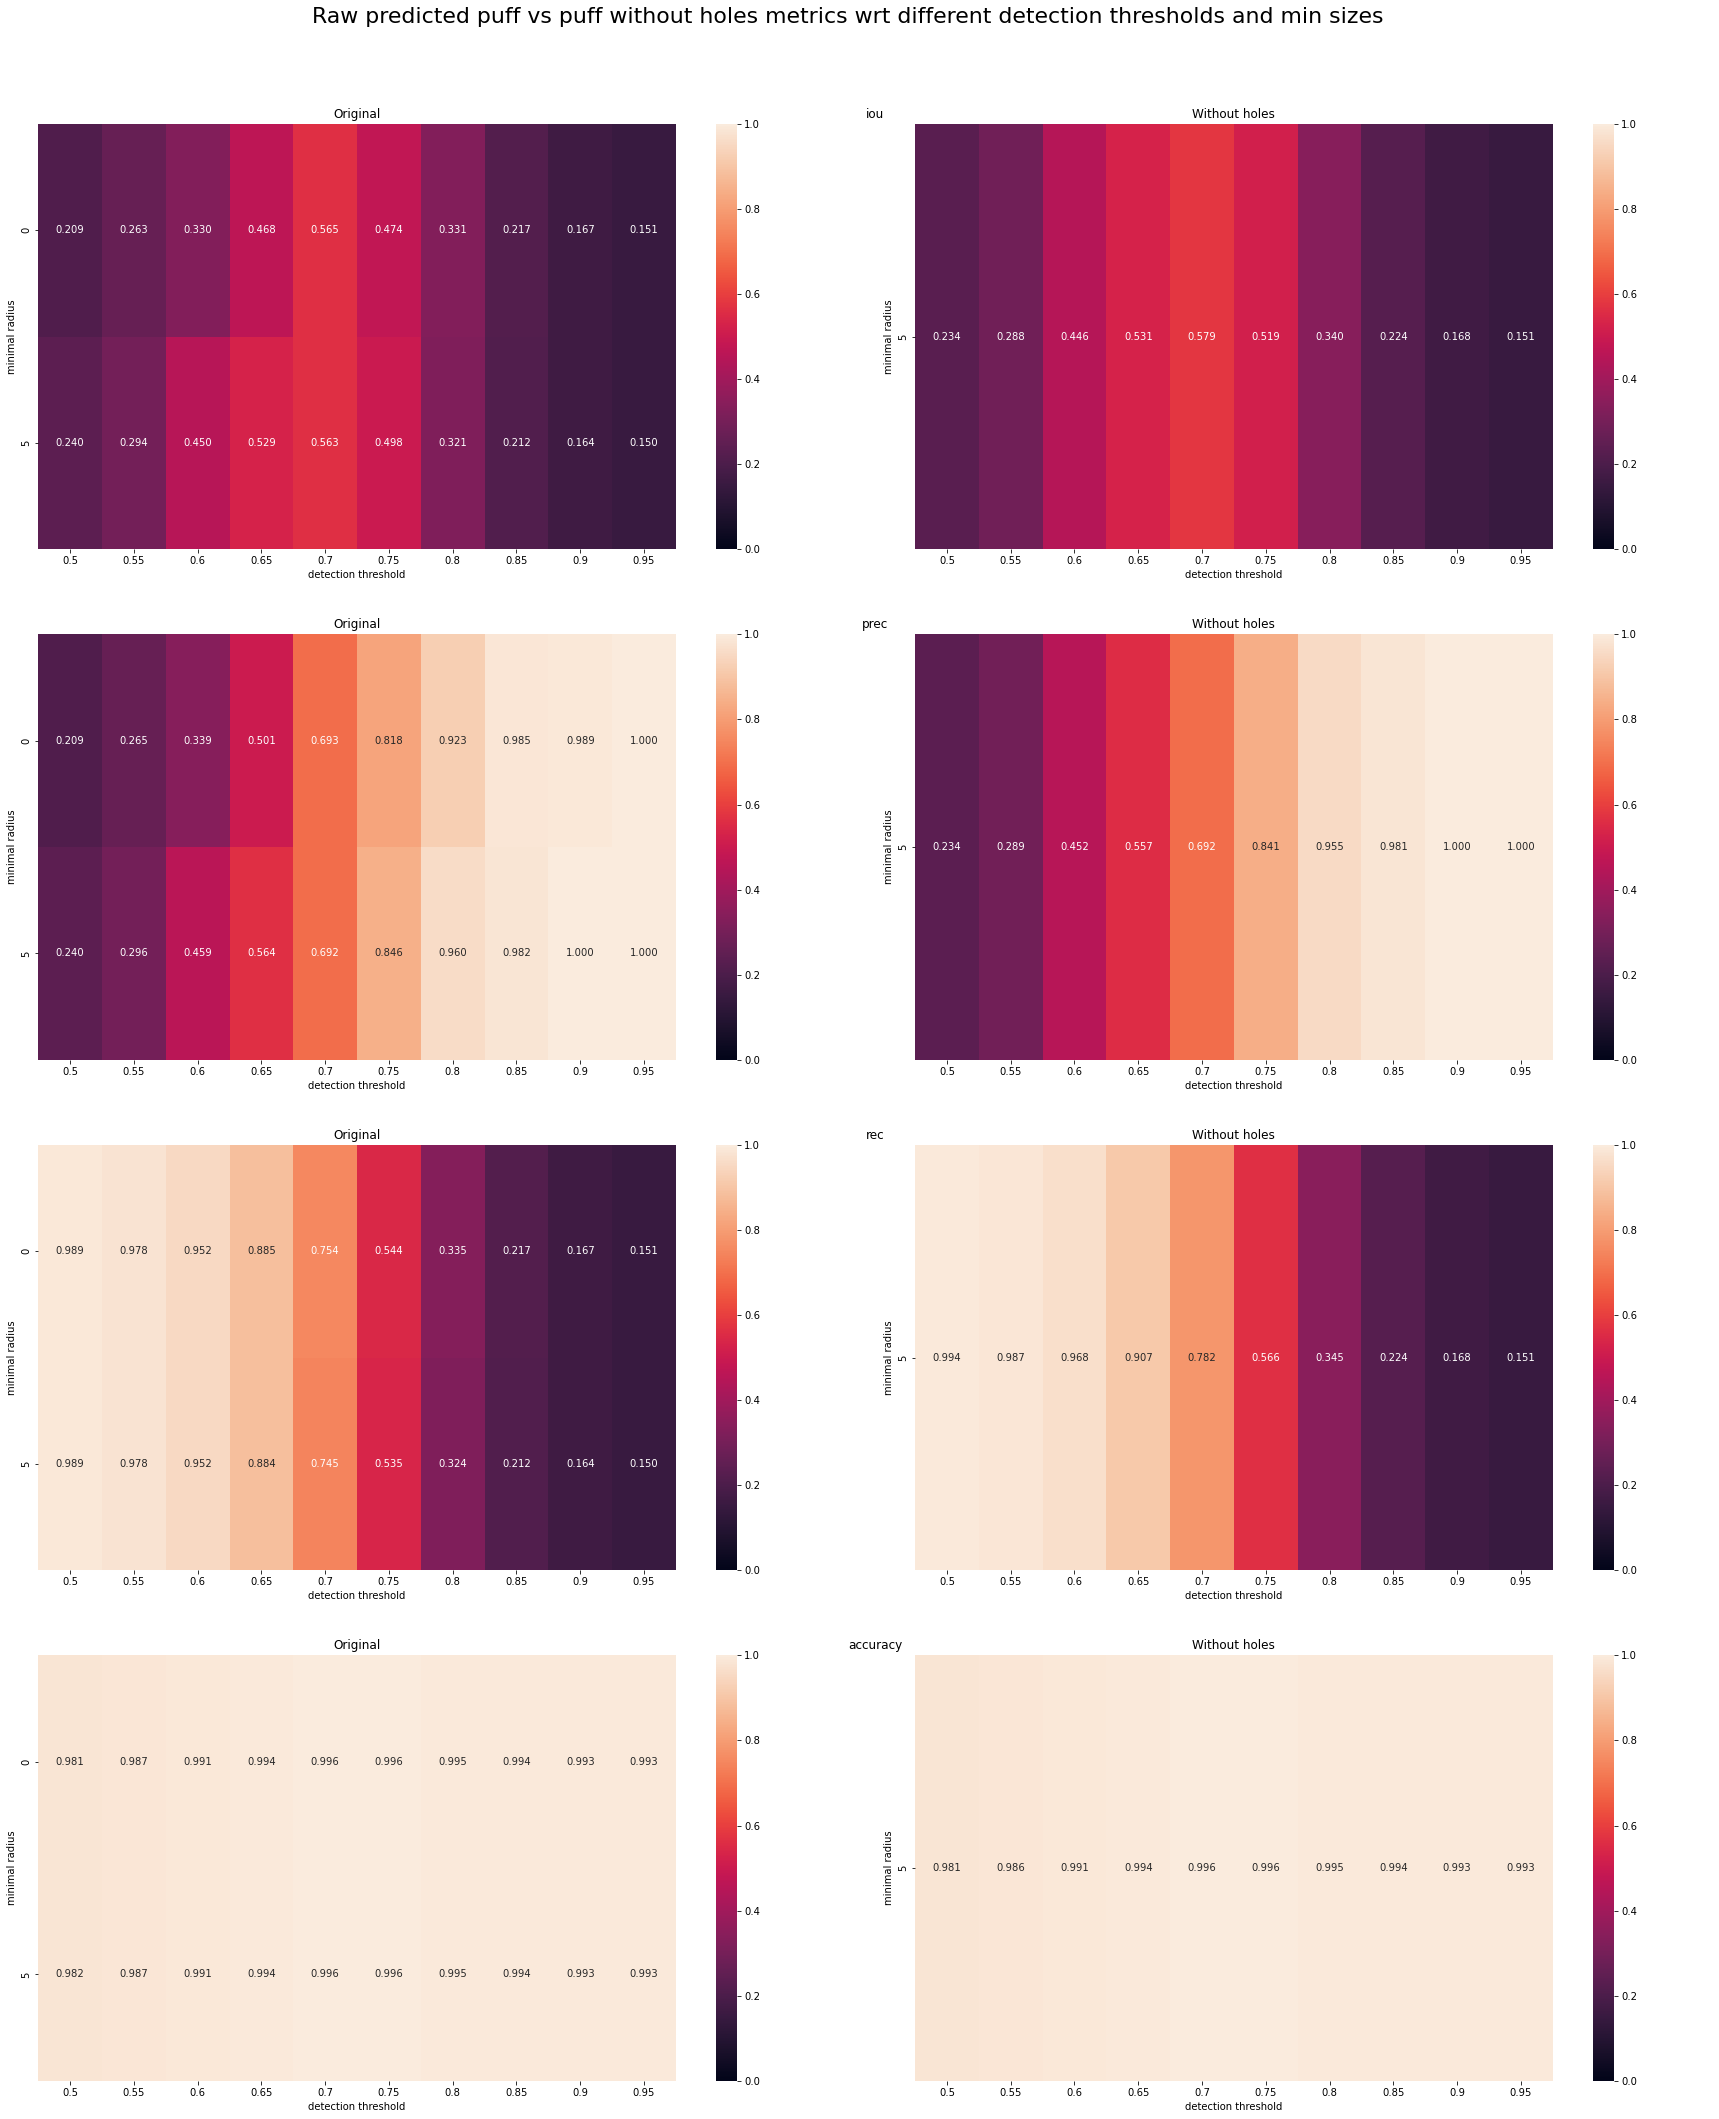

In [8]:
# visualise metrics for puffs with holes removed
fig = plt.figure(figsize=(30, 36))
fig.suptitle(f"Raw predicted puff vs puff without holes metrics wrt different detection thresholds and min sizes", fontsize=22, y=0.925)
outer = gridspec.GridSpec(4, 1, wspace=0.2, hspace=0.2)

plot_idx = 0
# loop through metrics and axes
for (metric, val_dict), (_, val_dict_no_holes) in zip(metrics_plot_dict.items(), metrics_no_holes_plot_dict.items()):
    # val_dict is detection_t x min_r
    
    # get dataframes
    df = pd.DataFrame.from_dict(val_dict)
    df_no_holes = pd.DataFrame.from_dict(val_dict_no_holes)
    df_no_holes.to_csv(os.path.join(data_folder,"df_puffs_no_holes_average_"+metric+".csv"))
    
    # plot metrics
    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[plot_idx], wspace=0.1, hspace=0.1)
    # set outer titles
    ax = plt.Subplot(fig, outer[plot_idx])
    ax.set_title(metric)
    ax.axis('off')
    fig.add_subplot(ax)
    plot_idx += 1
    
    ax = plt.Subplot(fig, inner[0])
    ax.set_title("Original")
    sns.heatmap(df, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
    ax.set_xlabel("detection threshold")
    ax.set_ylabel("minimal radius")
    fig.add_subplot(ax)
    
    ax = plt.Subplot(fig, inner[1])
    ax.set_title("Without holes")
    sns.heatmap(df_no_holes, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
    ax.set_xlabel("detection threshold")
    ax.set_ylabel("minimal radius")
    fig.add_subplot(ax)
    
    #ax.get_legend().remove()

plt.savefig(os.path.join(data_folder,"puff_no_holes_metrics_average_heatmaps.jpg"))
plt.show()

### For sample movie

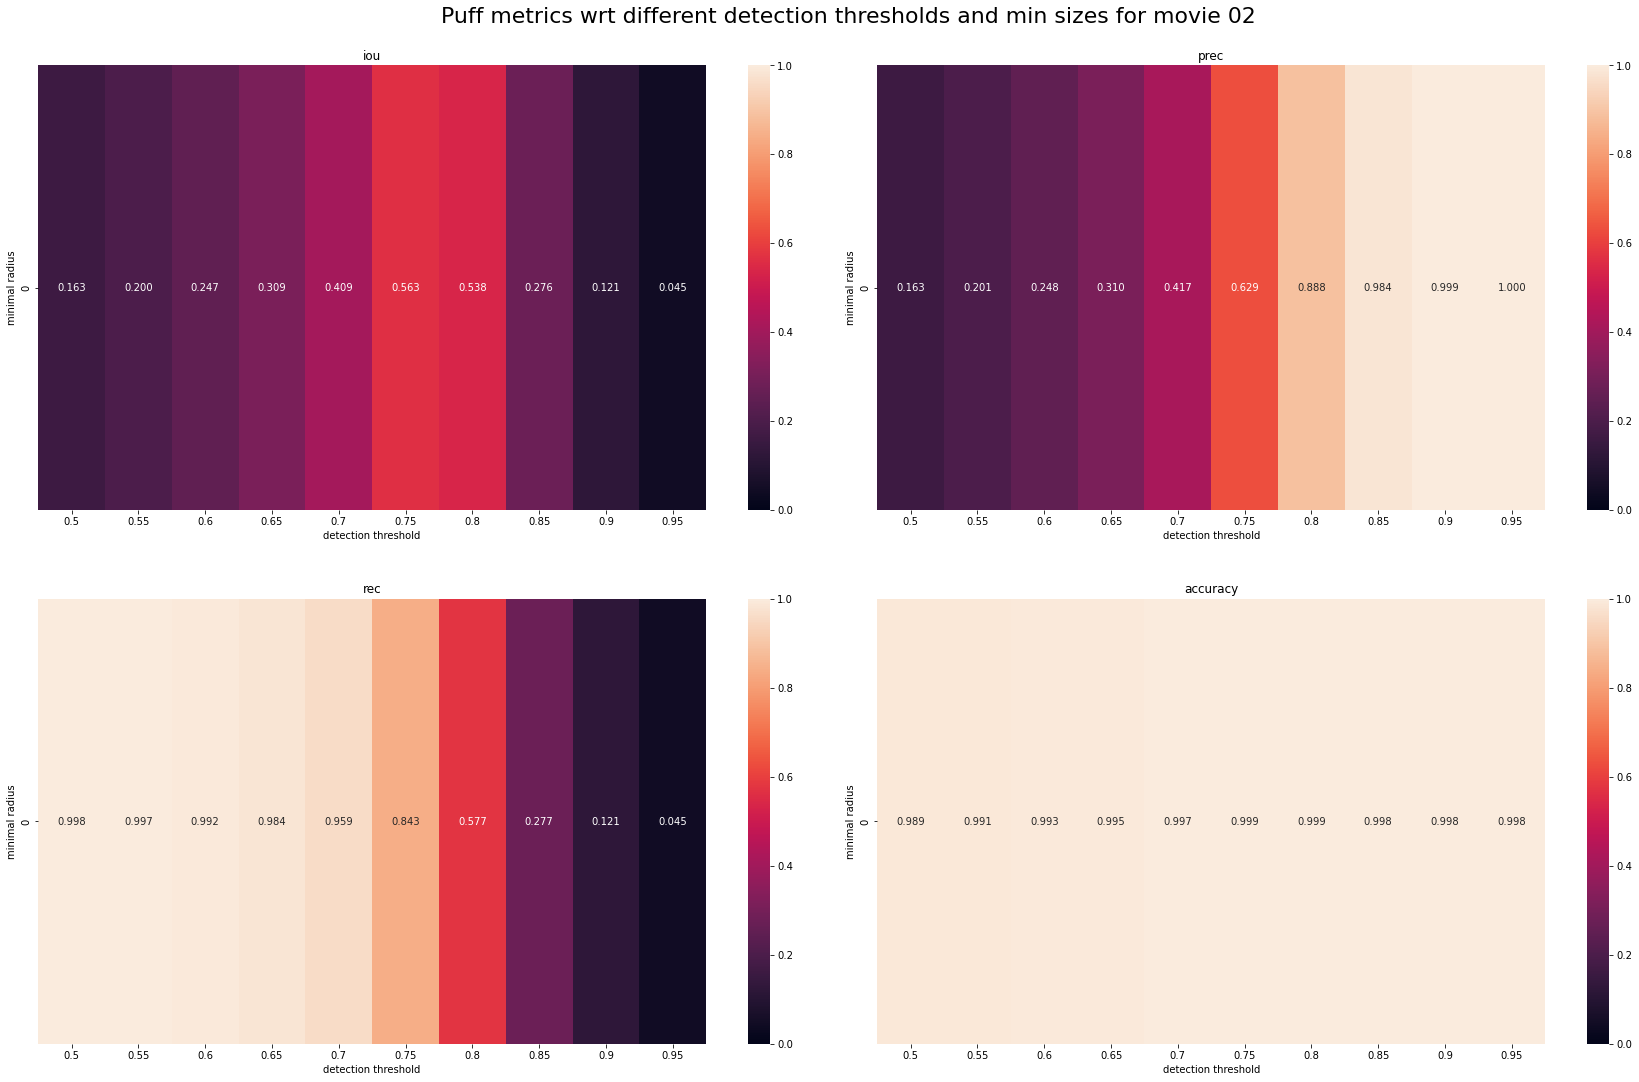

In [10]:
movie_id = '02'

# fix exclusion radius to zero (for puffs without holes, metrics has been computed only for exclusion_r = 0)
exclusion_r = '0'

# get dicts for sample movie, for fixed exclusion radius (metric x t x min_r)
sample_metrics_plot_dict = defaultdict(lambda: defaultdict(dict))
for t, min_r_metrics in metrics_puffs.items():
    for min_r, sample_metrics in min_r_metrics[exclusion_r].items():
        for metric, val in sample_metrics[movie_id].items():
            sample_metrics_plot_dict[metric][round(float(t),2)][min_r] = val

sample_metrics_no_holes_plot_dict = defaultdict(lambda: defaultdict(dict))
for t, min_r_metrics in metrics_puffs_no_holes.items():
    for min_r, sample_metrics in min_r_metrics.items():
        for metric, val in sample_metrics[movie_id].items():
            sample_metrics_no_holes_plot_dict[metric][round(float(t),2)][min_r] = val
            
# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 18))
plt.subplots_adjust(hspace=0.2, wspace=0.005)
fig.suptitle(f"Puff metrics wrt different detection thresholds and min sizes for movie "+movie_id, fontsize=22, y=0.925)

# loop through metrics and axes
for (metric, val_dict), ax in zip(sample_metrics_plot_dict.items(), axs.ravel()):
    # val_dict is detection_t x min_r
    
    # get dataframes
    df = pd.DataFrame.from_dict(val_dict)
    df.to_csv(os.path.join(data_folder,"df_puffs_movie_"+movie_id+"_"+metric+".csv"))
    
    # plot metrics
    ax.set_title(metric)
    sns.heatmap(df, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
    ax.set_xlabel("detection threshold")
    ax.set_ylabel("minimal radius")
    
    #ax.get_legend().remove()

plt.savefig(os.path.join(data_folder,"puff_metrics_movie_"+movie_id+"_heatmaps.jpg"))
plt.show()

#### Removing holes --> NOT USEFUL
Many predicted puff masks have holes inside the events due to the fact that sparks can appear on top of them.

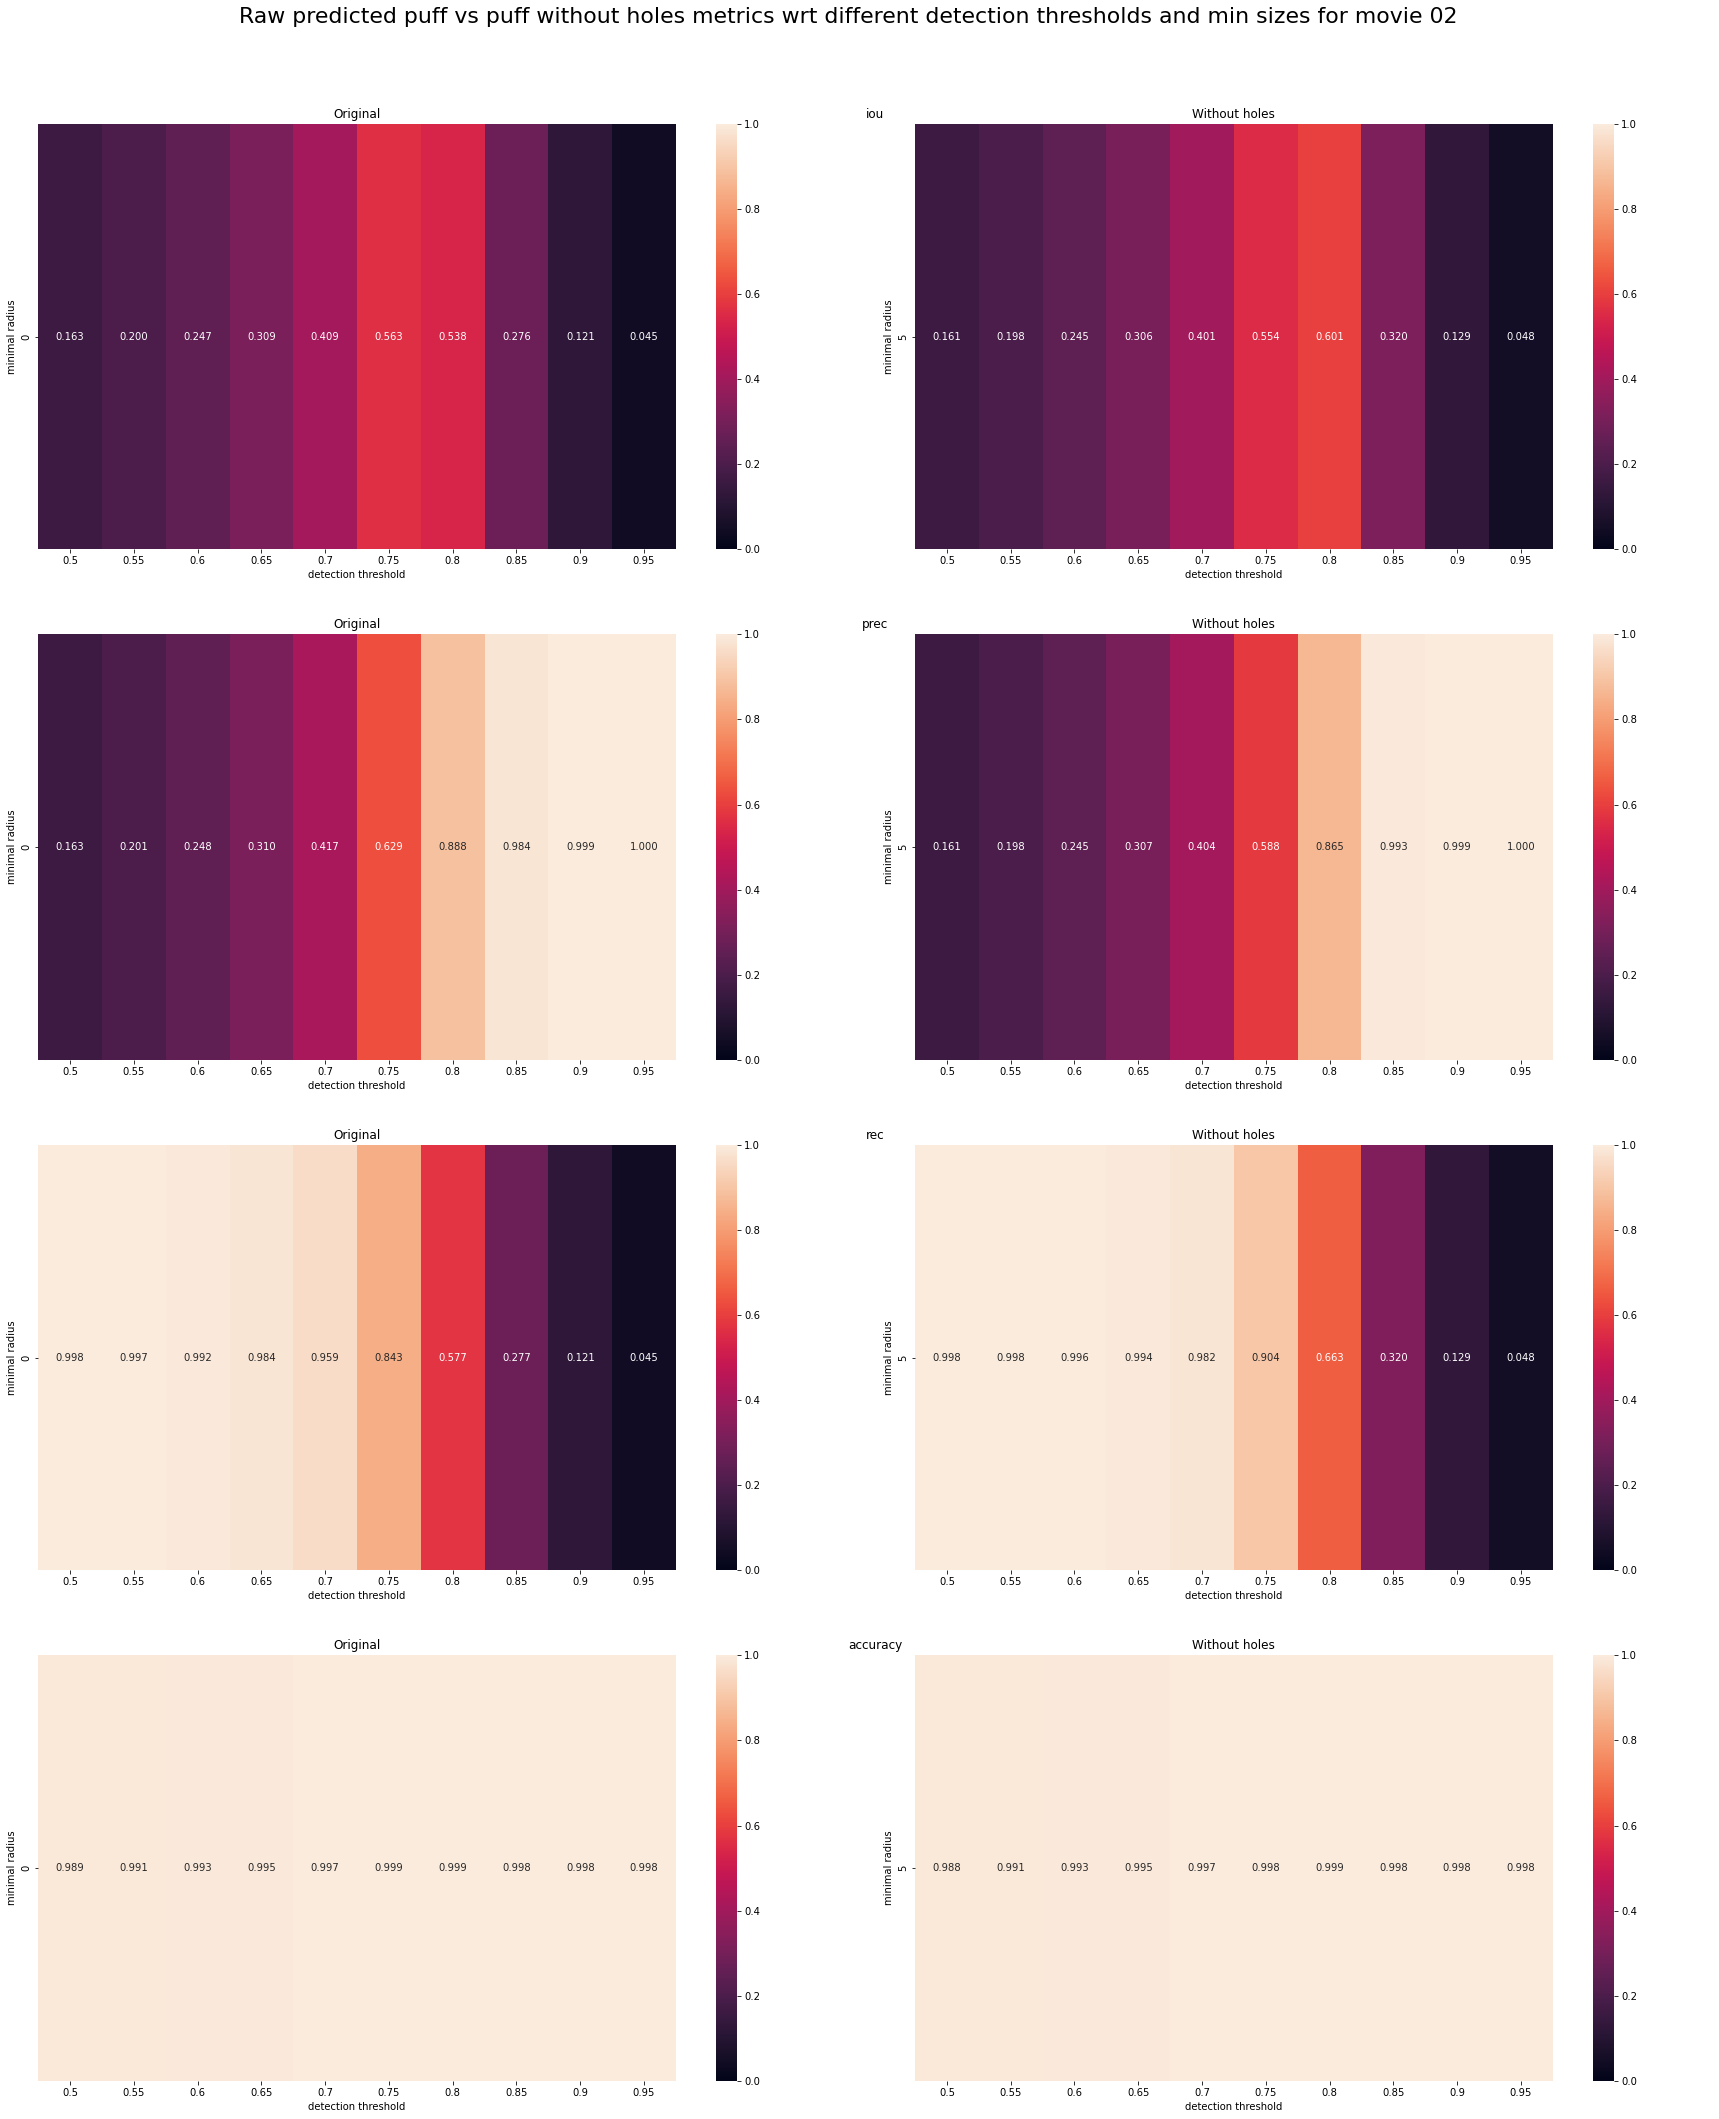

In [11]:
# visualise metrics for puffs with holes removed
fig = plt.figure(figsize=(30, 36))
fig.suptitle(f"Raw predicted puff vs puff without holes metrics wrt different detection thresholds and min sizes for movie "+movie_id, fontsize=22, y=0.925)
outer = gridspec.GridSpec(4, 1, wspace=0.2, hspace=0.2)

plot_idx = 0
# loop through metrics and axes
for (metric, val_dict), (_, val_dict_no_holes) in zip(sample_metrics_plot_dict.items(), sample_metrics_no_holes_plot_dict.items()):
    # val_dict is detection_t x min_r
    
    # get dataframes
    df = pd.DataFrame.from_dict(val_dict)
    df_no_holes = pd.DataFrame.from_dict(val_dict_no_holes)
    
    df_no_holes.to_csv(os.path.join(data_folder,"df_puffs_no_holes_movie_"+movie_id+"_"+metric+".csv"))
    
    # plot metrics
    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[plot_idx], wspace=0.1, hspace=0.1)
    # set outer titles
    ax = plt.Subplot(fig, outer[plot_idx])
    ax.set_title(metric)
    ax.axis('off')
    fig.add_subplot(ax)
    plot_idx += 1
    
    ax = plt.Subplot(fig, inner[0])
    ax.set_title("Original")
    sns.heatmap(df, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
    ax.set_xlabel("detection threshold")
    ax.set_ylabel("minimal radius")
    fig.add_subplot(ax)
    
    ax = plt.Subplot(fig, inner[1])
    ax.set_title("Without holes")
    sns.heatmap(df_no_holes, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
    ax.set_xlabel("detection threshold")
    ax.set_ylabel("minimal radius")
    fig.add_subplot(ax)
    
    #ax.get_legend().remove()

plt.savefig(os.path.join(data_folder,"puff_no_holes_metrics_movie_"+movie_id+"_heatmaps.jpg"))
plt.show()

## Visualise metrics for fixed detection threshold and min size wrt to exclusion radius

Fixing `t_detection_puffs = 0.65` with `min_radius_puffs = 5`

In [12]:
t_puffs = '0.65'
min_r_puffs = '5'

In [13]:
# rename metrics_puffs and metrics_puffs_average keys !!
for old_key in metrics_puffs.fromkeys(metrics_puffs):
    new_key = old_key[:4]
    metrics_puffs[new_key] = metrics_puffs.pop(old_key)
    metrics_puffs_average[new_key] = metrics_puffs_average.pop(old_key)

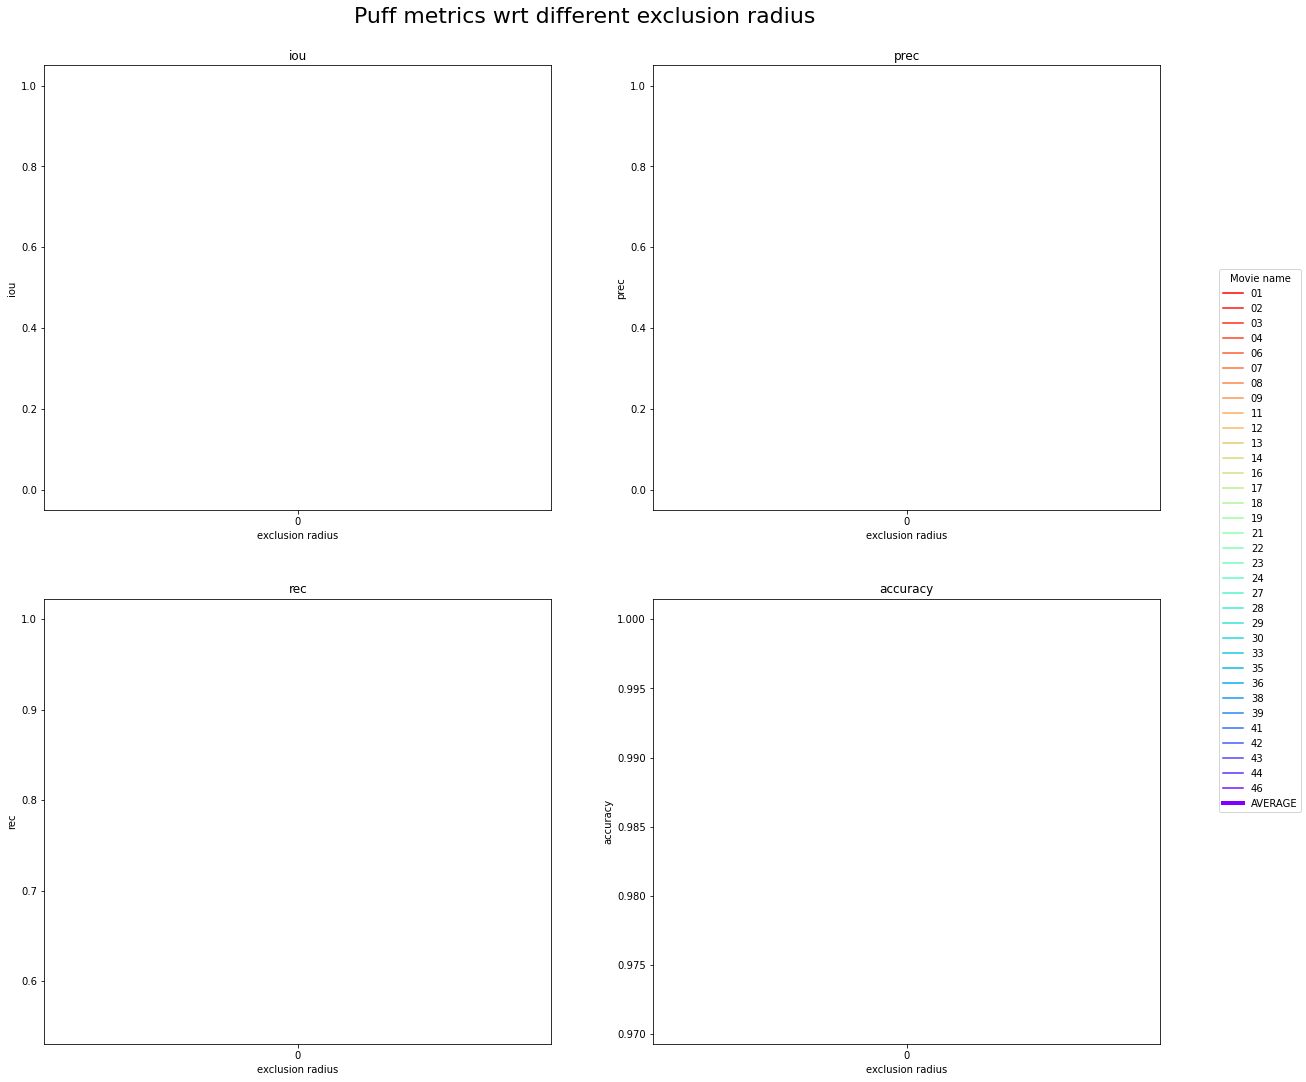

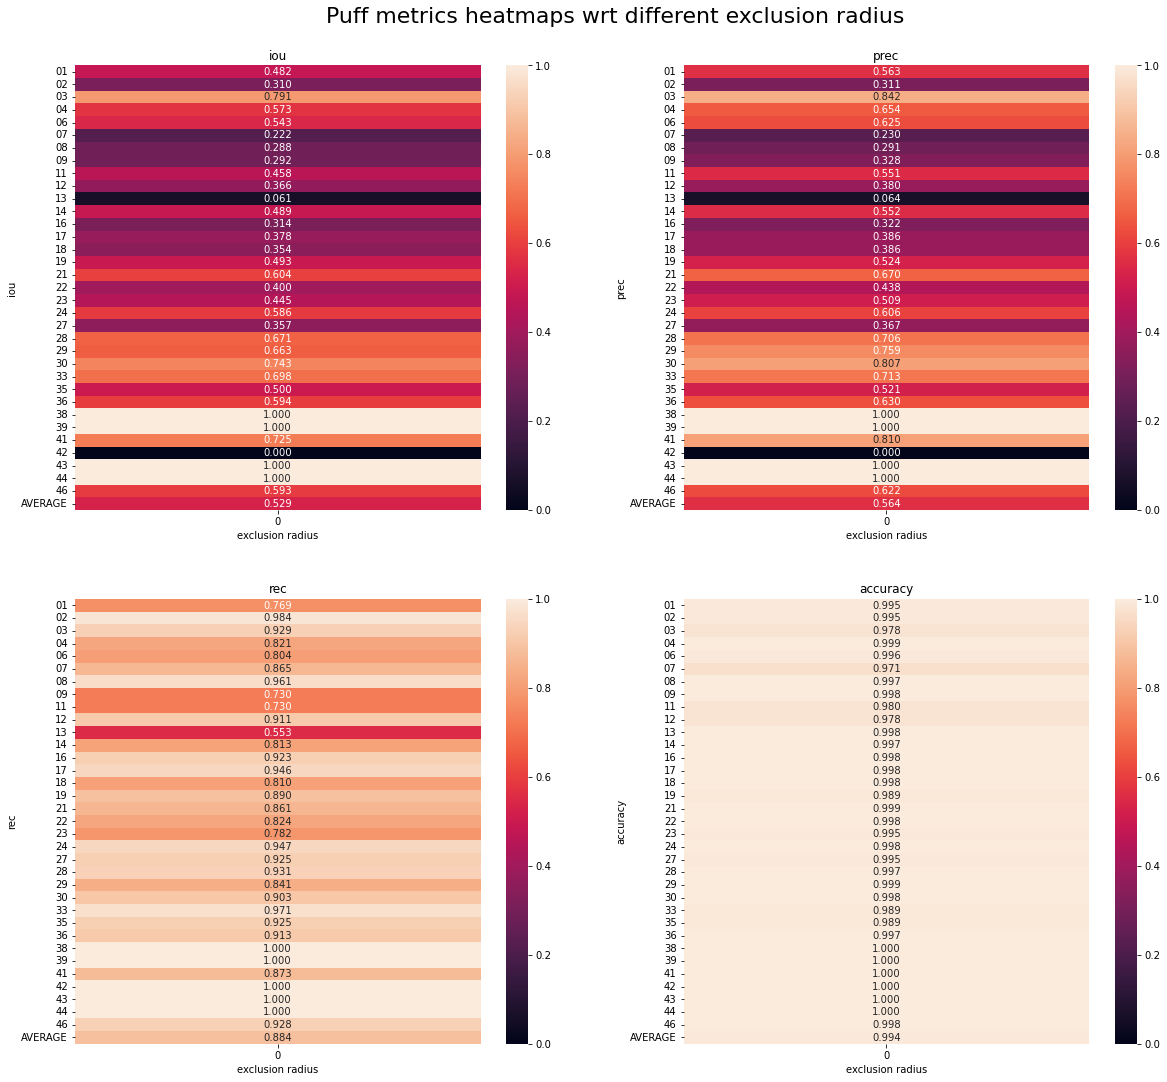

In [14]:
# get dicts for single movies
dict_exclusion_r_plot = defaultdict(lambda: defaultdict(dict)) # exclusion r x video name x metric 
for exclusion_r, video_metrics in metrics_puffs[t_puffs][min_r_puffs].items():
    for movie_name, metrics in video_metrics.items():
        for metric, val in metrics.items():
            dict_exclusion_r_plot[metric][movie_name][exclusion_r] = val

# add average to single movies' dict
for exclusion_r, metric_dict in metrics_puffs_average[t_puffs][min_r_puffs].items():
    for metric, val in metric_dict.items():
        dict_exclusion_r_plot[metric]['AVERAGE'][exclusion_r] = val

# visualise metrics with respect to exclusion radius
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 18))
#plt.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle(f"Puff metrics wrt different exclusion radius", fontsize=22, y=0.925)

# loop through metrics and axes
for (metric, val_dict), ax in zip(dict_exclusion_r_plot.items(), axs.ravel()):
    # val_dict is movie_name x exclusion_r
    
    # get dataframes
    df = pd.DataFrame.from_dict(val_dict).T
    df.to_csv(os.path.join(data_folder,"df_puffs_exclusion_radius_"+metric+".csv"))
    
    # plot metrics
    ax.set_title(metric)
    
    color = iter(cm.rainbow_r(np.linspace(0, 1, len(val_dict.keys()))))
    for movie_id, metrics in val_dict.items():
        linewidth= 1.5 if movie_id != 'AVERAGE' else 4
        c = next(color)
        ax.plot(metrics.keys(), metrics.values(), label=movie_id, linewidth=linewidth, c=c)
    
    ax.set_xlabel("exclusion radius")
    ax.set_ylabel(metric)
    
    #ax.get_legend().remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title="Movie name")
    
plt.savefig(os.path.join(data_folder,"puff_metrics_exclusion_radius.jpg"))
plt.show()

# heatmap
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 18))
#plt.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle(f"Puff metrics heatmaps wrt different exclusion radius", fontsize=22, y=0.925)

# loop through metrics and axes
for (metric, val_dict), ax in zip(dict_exclusion_r_plot.items(), axs.ravel()):
    # val_dict is movie_name x exclusion_r
    
    # get dataframes
    df = pd.DataFrame.from_dict(val_dict).T
    
    # plot metrics
    ax.set_title(metric)
    sns.heatmap(df, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
    ax.set_xlabel("exclusion radius")
    ax.set_ylabel(metric)
    
plt.savefig(os.path.join(data_folder,"puff_metrics_exclusion_radius_heatmaps.jpg"))
plt.show()

### Remarks:
- would training using e.g. Dice loss make sense? Is it feasible?
- by increasing exclusion radius, some corrected predicted puffs "disappear", making IoU worse
- should apply exlcusion radius to ignored events, too?

## Waves metrics for all thresholds (IoU score, pixel accuracy, precision, recall)

- UNet's output processing:
    - threshold is applied to output
    - remove small object with size < 2 * min_radius * n_dims (can be changed)
    - empty marginal frames (not used by loss function)
- Metrics computation:
    - compute true positive (tp), true negative (tn), false positive (fp) and false negative (fn) pixels
    - if exclusion radius > 0
        - compute annotations dilation, erosion and finally exclusion mask
        - compute intersection of tp, tn, fp, fn with exclusion mask
    - if using an ignore mask
        - compute dilation of ignore mask, if using the exclusion radius
        - compute intersection of tp, tn, fp, fn with (not) ignore mask
    - compute all metrics according to definition

### Get dicts containing wave metrics and visualise them, with exclusion_radius = 0

### Average over all movies

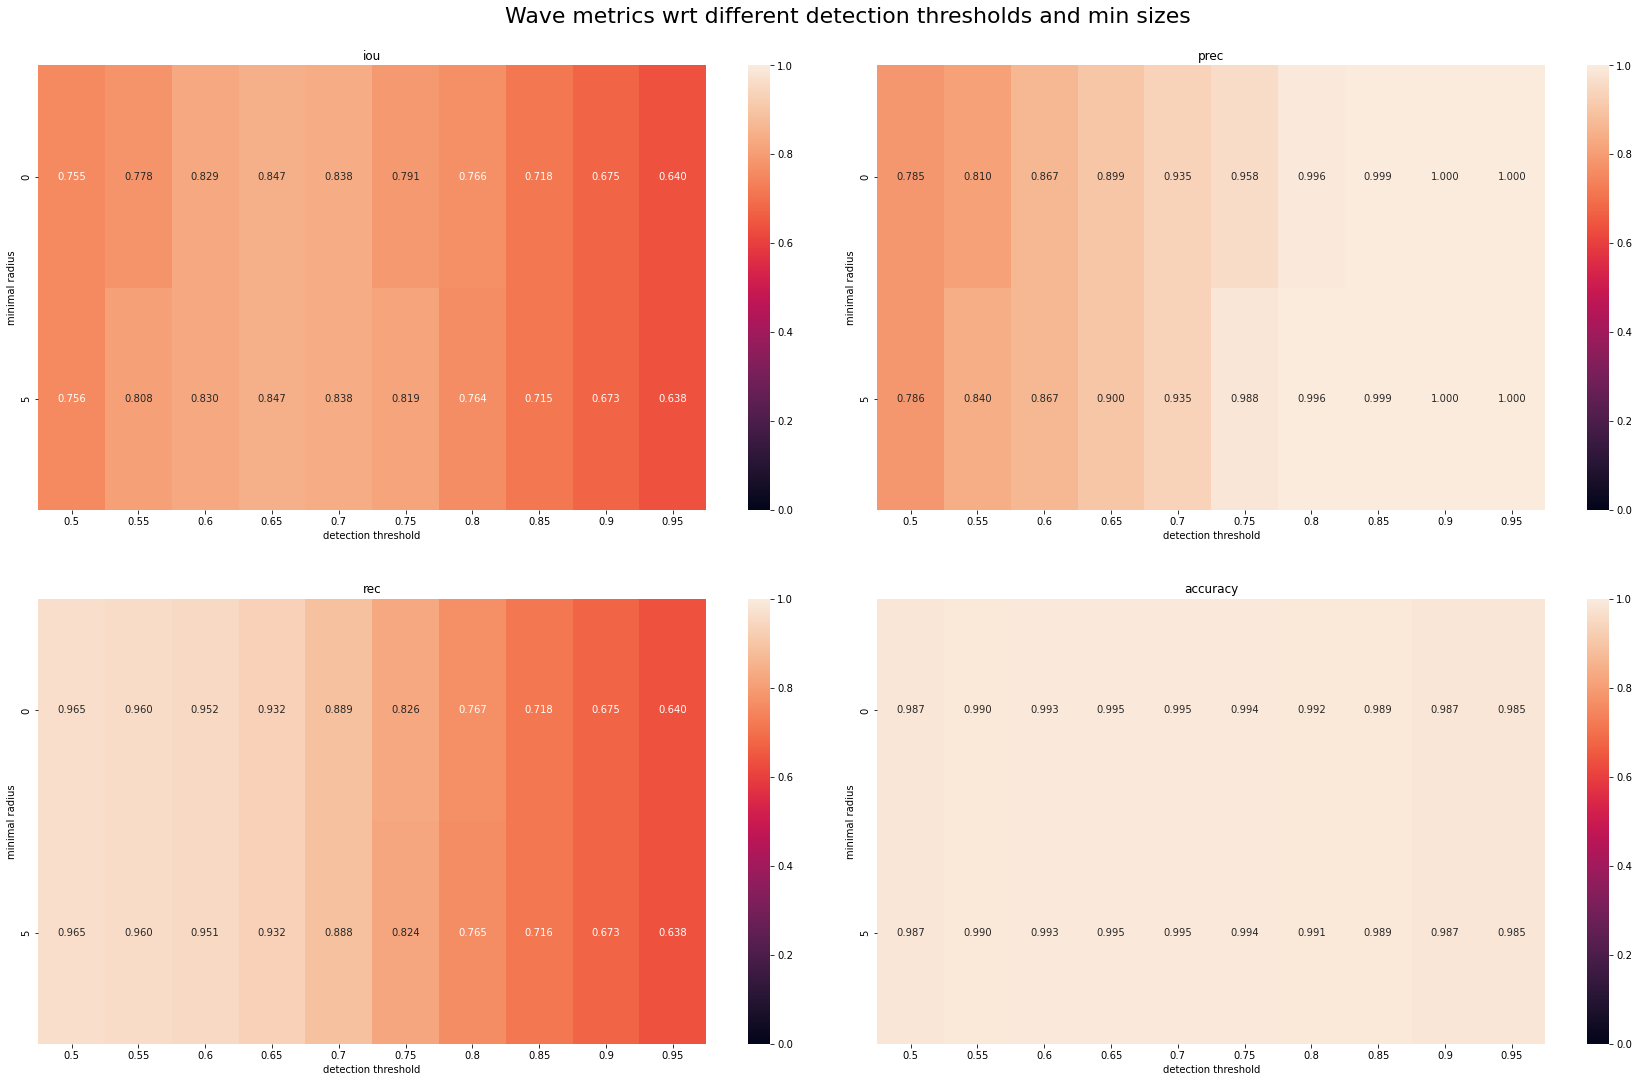

In [15]:
# fix exclusion radius to zero
exclusion_r = '0'

# get dicts for fixed exclusion radius (metric x t x min_r)
metrics_plot_dict = defaultdict(lambda: defaultdict(dict))
for t, min_r_metrics in metrics_waves_average.items():
    for min_r, exclusion_r_metrics in min_r_metrics.items():
        for metric, val in exclusion_r_metrics[exclusion_r].items():
            metrics_plot_dict[metric][round(float(t),2)][min_r] = val
            
# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 18))
plt.subplots_adjust(hspace=0.2, wspace=0.005)
fig.suptitle(f"Wave metrics wrt different detection thresholds and min sizes", fontsize=22, y=0.925)

# loop through metrics and axes
for (metric, val_dict), ax in zip(metrics_plot_dict.items(), axs.ravel()):
    # val_dict is detection_t x min_r
    
    # get dataframes
    df = pd.DataFrame.from_dict(val_dict)
    
    # plot metrics
    ax.set_title(metric)
    sns.heatmap(df, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
    ax.set_xlabel("detection threshold")
    ax.set_ylabel("minimal radius")
    
    #ax.get_legend().remove()

plt.savefig(os.path.join(data_folder,"wave_metrics_average_heatmaps.jpg"))
plt.show()

### For sample movie

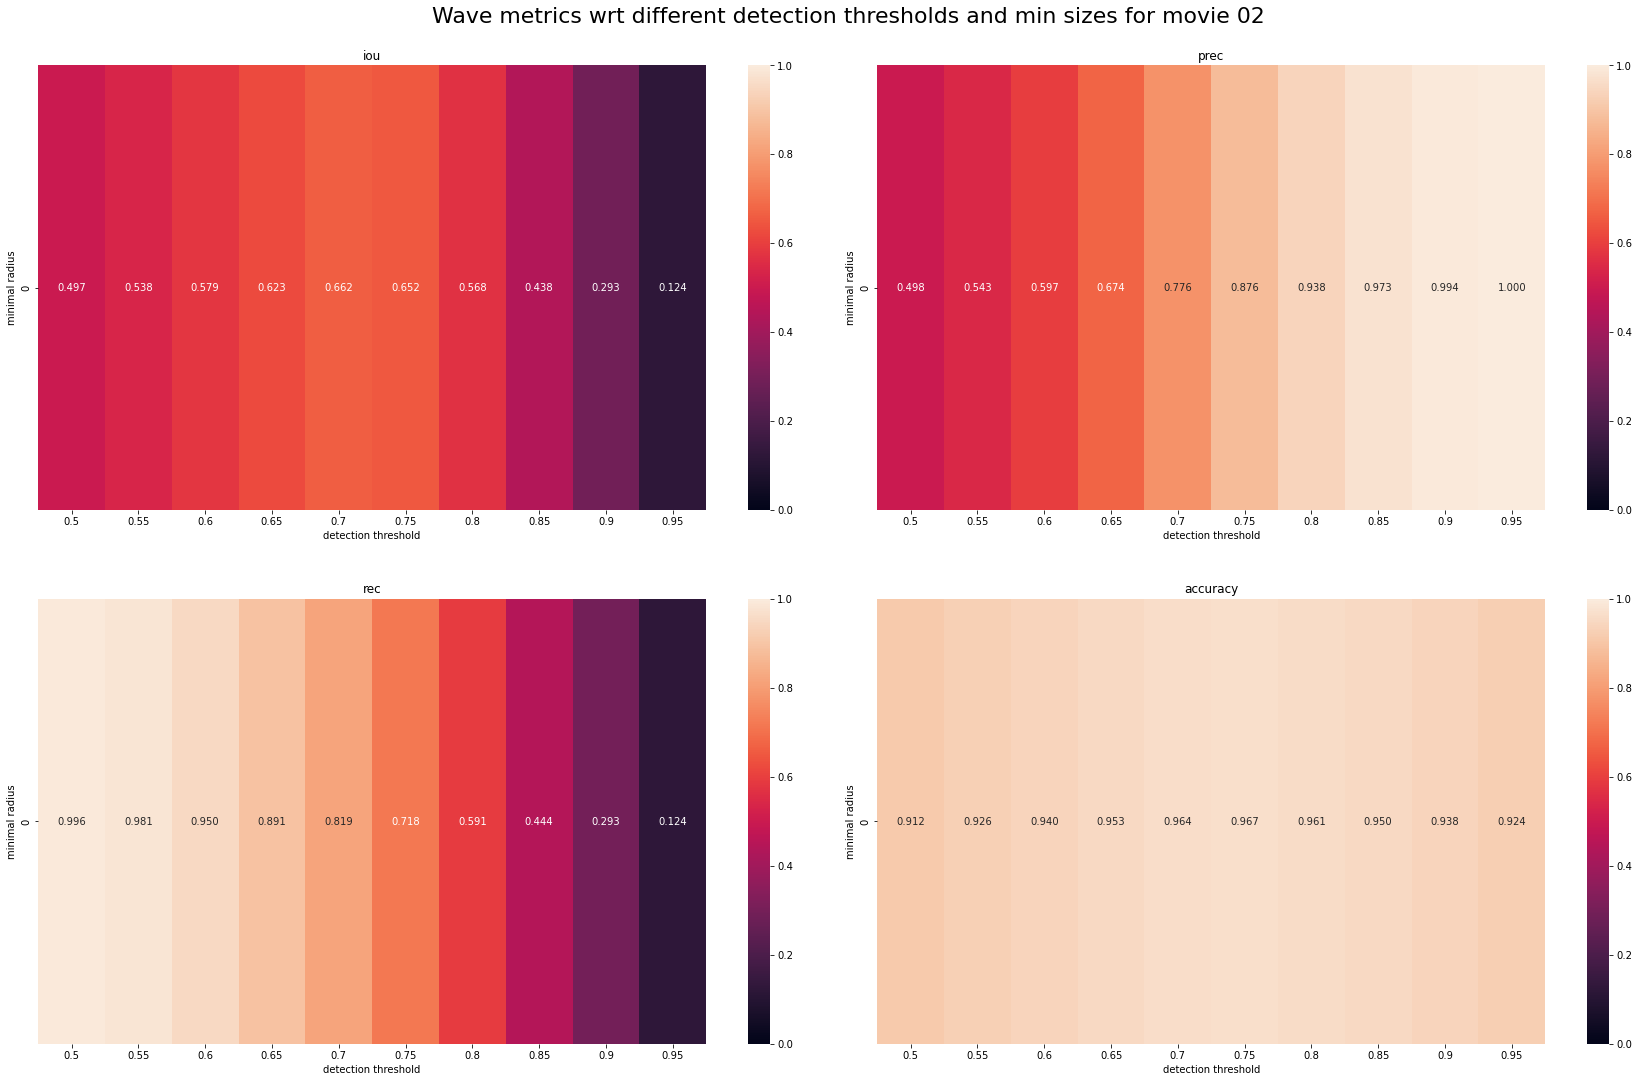

In [16]:
movie_id = '02'

# fix exclusion radius to zero
exclusion_r = '0'

# get dicts for sample movie, for fixed exclusion radius (metric x t x min_r)
sample_metrics_plot_dict = defaultdict(lambda: defaultdict(dict))
for t, min_r_metrics in metrics_waves.items():
    for min_r, sample_metrics in min_r_metrics[exclusion_r].items():
        for metric, val in sample_metrics[movie_id].items():
            sample_metrics_plot_dict[metric][round(float(t),2)][min_r] = val
            
# define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 18))
plt.subplots_adjust(hspace=0.2, wspace=0.005)
fig.suptitle(f"Wave metrics wrt different detection thresholds and min sizes for movie "+movie_id, fontsize=22, y=0.925)

# loop through metrics and axes
for (metric, val_dict), ax in zip(sample_metrics_plot_dict.items(), axs.ravel()):
    # val_dict is detection_t x min_r
    
    # get dataframes
    df = pd.DataFrame.from_dict(val_dict)
    
    # plot metrics
    ax.set_title(metric)
    sns.heatmap(df, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
    ax.set_xlabel("detection threshold")
    ax.set_ylabel("minimal radius")
    
    #ax.get_legend().remove()

plt.savefig(os.path.join(data_folder,"wave_metrics_movie_"+movie_id+"_heatmaps.jpg"))
plt.show()

**Remark:** Compared to training with standard cross entropy loss, results are much better, but detection threshold need to be lowered.

### Visualise metrics for fixed detection threshold and min size wrt to exclusion radius

Fixing `t_detection_waves = 0.6` with `min_radius_waves = 0`

In [20]:
t_waves = '0.6'
min_r_waves = '0'

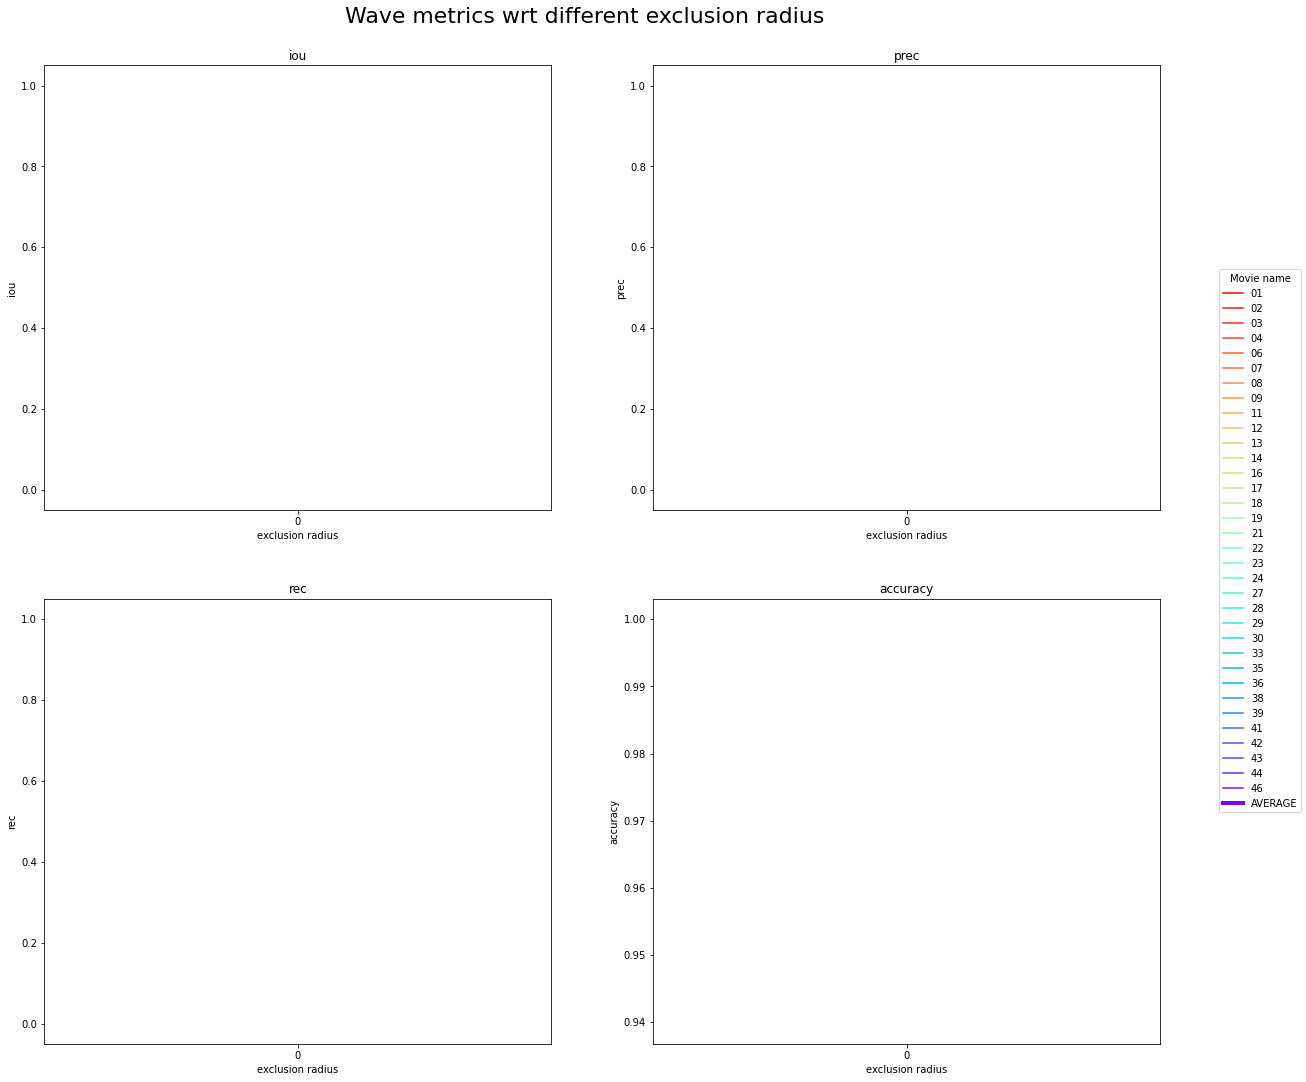

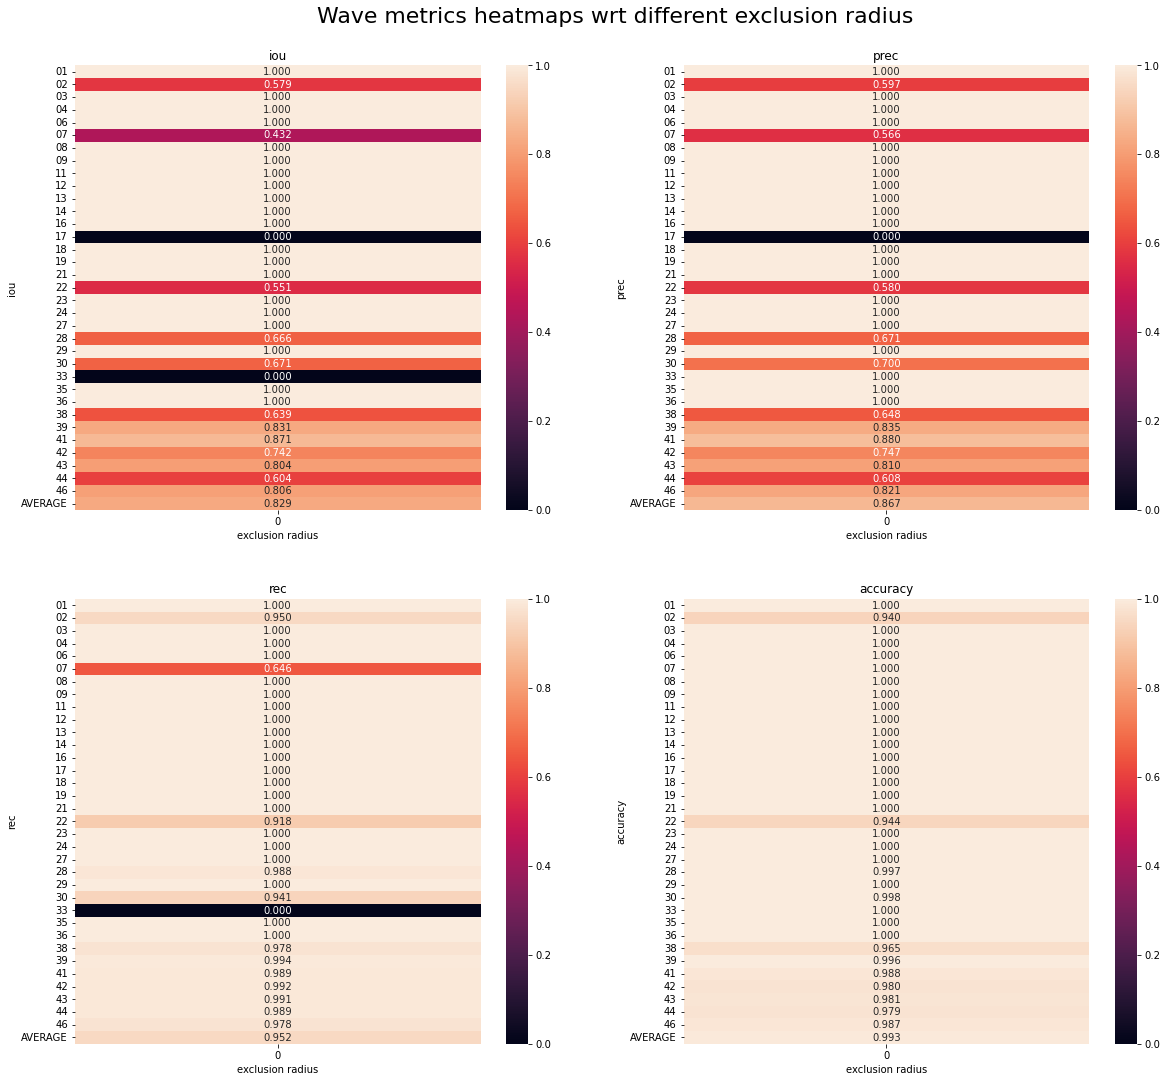

In [21]:
# rename metrics_waves and metrics_waves_average keys !!
for old_key in metrics_waves.fromkeys(metrics_waves):
    new_key = old_key[:4]
    metrics_waves[new_key] = metrics_waves.pop(old_key)
    metrics_waves_average[new_key] = metrics_waves_average.pop(old_key)

# get dicts for single movies
dict_exclusion_r_plot = defaultdict(lambda: defaultdict(dict)) # exclusion r x video name x metric 
for exclusion_r, video_metrics in metrics_waves[t_waves][min_r_waves].items():
    for movie_name, metrics in video_metrics.items():
        for metric, val in metrics.items():
            dict_exclusion_r_plot[metric][movie_name][exclusion_r] = val

# add average to single movies' dict
for exclusion_r, metric_dict in metrics_waves_average[t_waves][min_r_waves].items():
    for metric, val in metric_dict.items():
        dict_exclusion_r_plot[metric]['AVERAGE'][exclusion_r] = val

# visualise metrics with respect to exclusion radius
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 18))
#plt.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle(f"Wave metrics wrt different exclusion radius", fontsize=22, y=0.925)

# loop through metrics and axes
for (metric, val_dict), ax in zip(dict_exclusion_r_plot.items(), axs.ravel()):
    # val_dict is movie_name x exclusion_r
    
    # get dataframes
    df = pd.DataFrame.from_dict(val_dict).T
    df.to_csv(os.path.join(data_folder,"df_waves_exclusion_radius_"+metric+".csv"))
    
    # plot metrics
    ax.set_title(metric)
    
    color = iter(cm.rainbow_r(np.linspace(0, 1, len(val_dict.keys()))))
    for movie_id, metrics in val_dict.items():
        linewidth= 1.5 if movie_id != 'AVERAGE' else 4
        c = next(color)
        ax.plot(metrics.keys(), metrics.values(), label=movie_id, linewidth=linewidth, c=c)
    
    ax.set_xlabel("exclusion radius")
    ax.set_ylabel(metric)
    
    #ax.get_legend().remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', title="Movie name")
    
plt.savefig(os.path.join(data_folder,"wave_metrics_exclusion_radius.jpg"))
plt.show()

# heatmap
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 18))
#plt.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle(f"Wave metrics heatmaps wrt different exclusion radius", fontsize=22, y=0.925)

# loop through metrics and axes
for (metric, val_dict), ax in zip(dict_exclusion_r_plot.items(), axs.ravel()):
    # val_dict is movie_name x exclusion_r
    
    # get dataframes
    df = pd.DataFrame.from_dict(val_dict).T
    
    # plot metrics
    ax.set_title(metric)
    sns.heatmap(df, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
    ax.set_xlabel("exclusion radius")
    ax.set_ylabel(metric)
    
plt.savefig(os.path.join(data_folder,"wave_metrics_exclusion_radius_heatmaps.jpg"))
plt.show()

## Joined predictions for puff and wave metrics

Visualise metrics for summed predictions of puffs and waves, to check whether big events are generally detected (even if misclassified).

### Get dicts containing puff+wave metrics and visualise them, with exclusion_radius = 0

#### Average over all movies

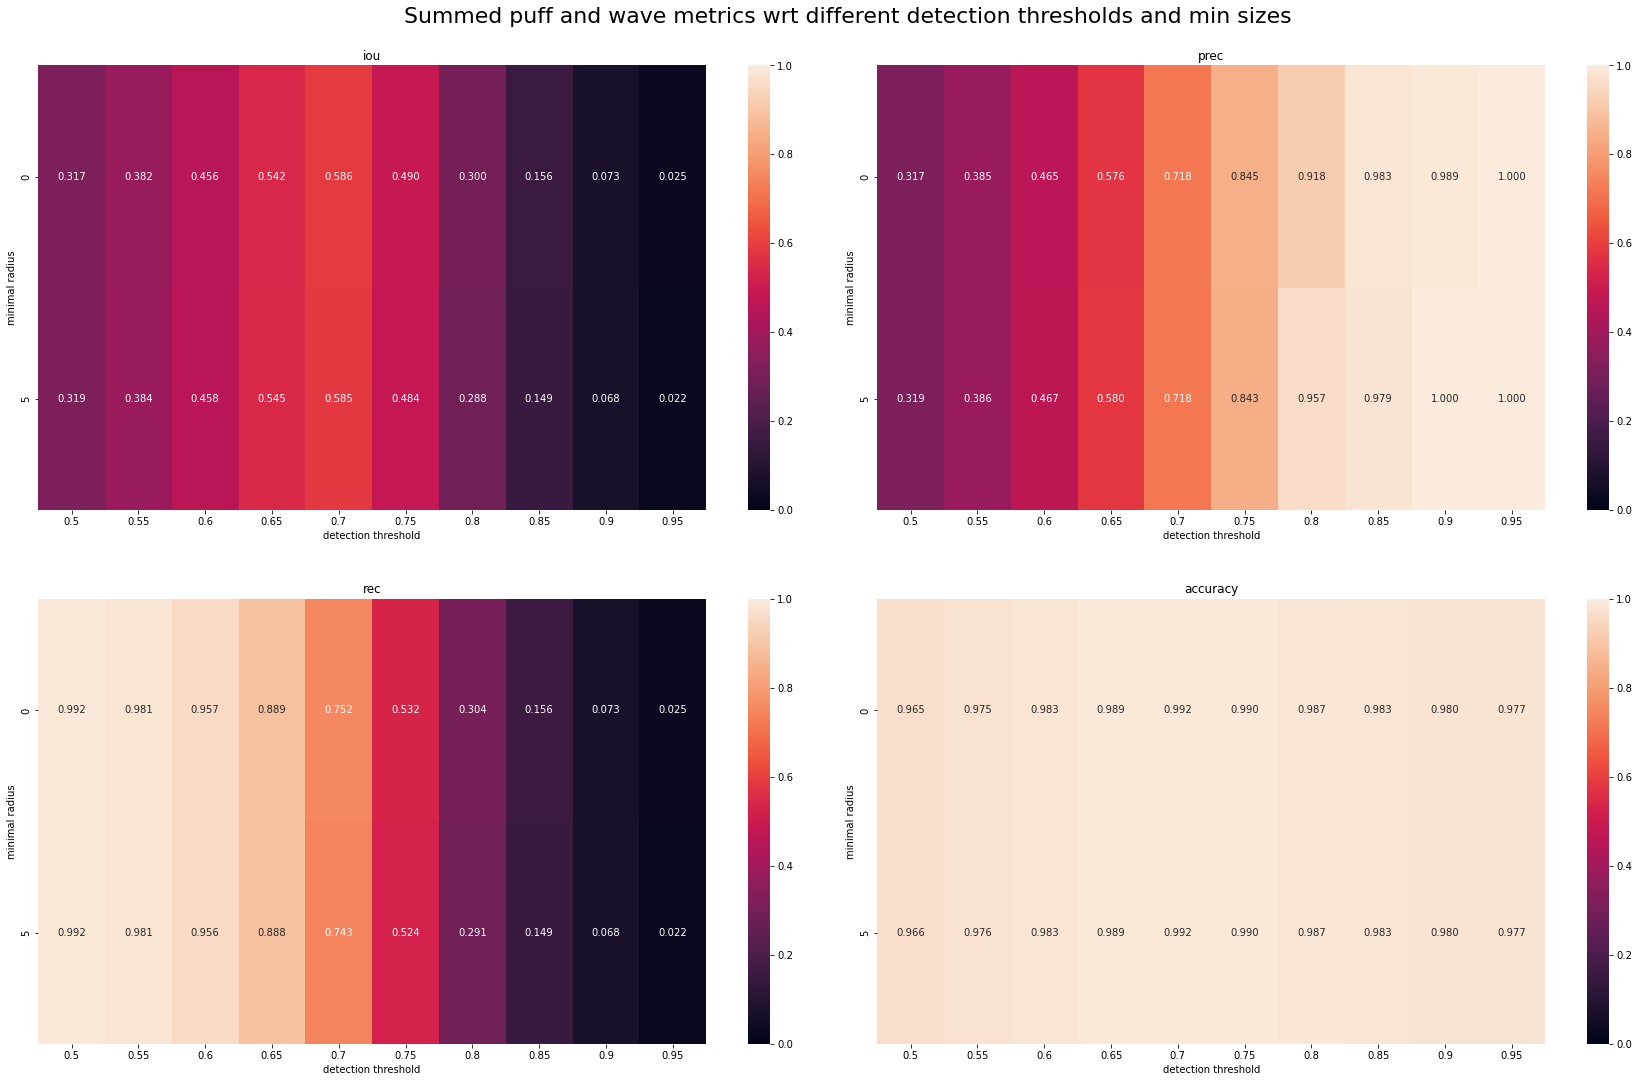

In [22]:
# fix exclusion radius to zero

# get dicts for fixed exclusion radius (metric x t x min_r)
metrics_plot_dict = defaultdict(lambda: defaultdict(dict))
for t, min_r_metrics in metrics_joined_puffs_waves_average.items():
    for min_r, exclusion_r_metrics in min_r_metrics.items():
        for metric, val in exclusion_r_metrics[exclusion_r].items():
            metrics_plot_dict[metric][round(float(t),2)][min_r] = val
            
# visualise metrics for raw predicted puffs
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 18))
plt.subplots_adjust(hspace=0.2, wspace=0.005)
fig.suptitle(f"Summed puff and wave metrics wrt different detection thresholds and min sizes", fontsize=22, y=0.925)

# loop through metrics and axes
for (metric, val_dict), ax in zip(metrics_plot_dict.items(), axs.ravel()):
    # val_dict is detection_t x min_r
    
    # get dataframes
    df = pd.DataFrame.from_dict(val_dict)
    df.to_csv(os.path.join(data_folder,"df_joined_puffs_waves_average_"+metric+".csv"))
    
    # plot metrics
    ax.set_title(metric)
    sns.heatmap(df, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
    ax.set_xlabel("detection threshold")
    ax.set_ylabel("minimal radius")
    
    #ax.get_legend().remove()

plt.savefig(os.path.join(data_folder,"joined_puffs_waves_metrics_average_heatmaps.jpg"))
plt.show()

## Joined predictions for puff and spark metrics

Visualise metrics for summed predictions of puffs and sparks, to check whether events are generally detected (even if misclassified).

**Remark:** sparks are trained with peaks, but here they are compared with RAW annotations (TODO: try with peaks & ignore mask?)

### Get dicts containing puff+spark metrics and visualise them, with exclusion_radius = 0

#### Average over all movies

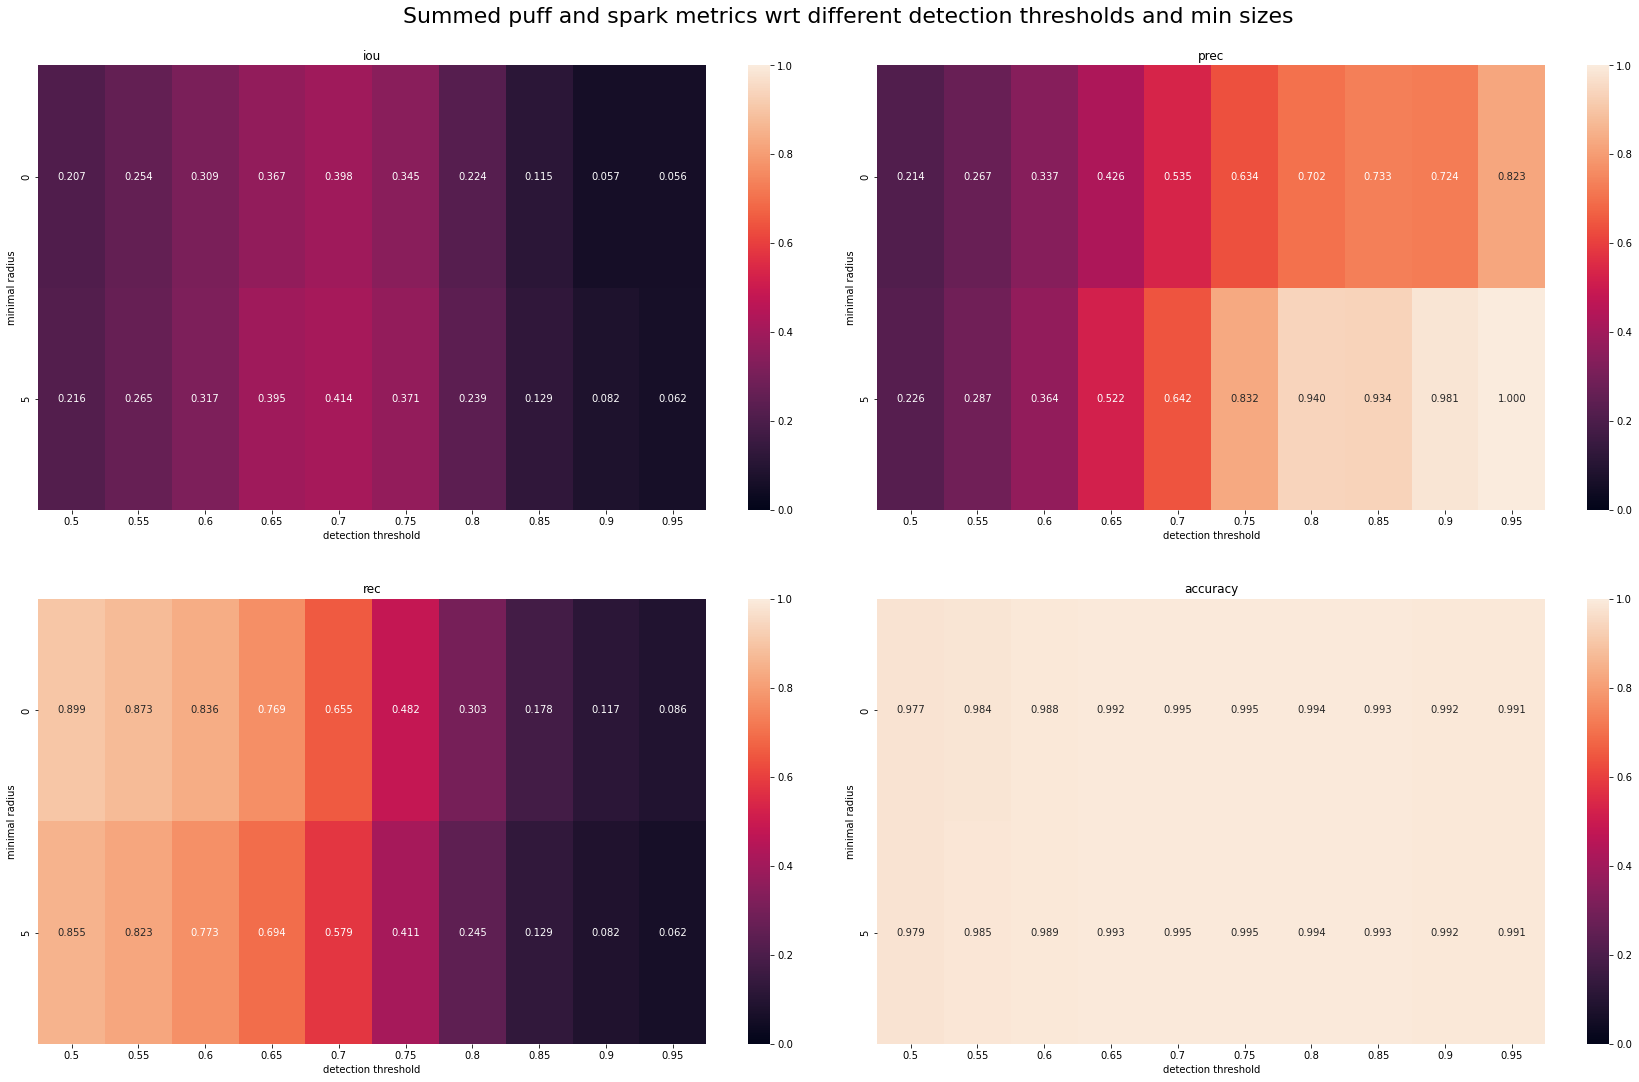

In [23]:
# fix exclusion radius to zero

# get dicts for fixed exclusion radius (metric x t x min_r)
metrics_plot_dict = defaultdict(lambda: defaultdict(dict))
for t, min_r_metrics in metrics_joined_puffs_sparks_average.items():
    for min_r, exclusion_r_metrics in min_r_metrics.items():
        for metric, val in exclusion_r_metrics[exclusion_r].items():
            metrics_plot_dict[metric][round(float(t),2)][min_r] = val
            
# visualise metrics for raw predicted puffs
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 18))
plt.subplots_adjust(hspace=0.2, wspace=0.005)
fig.suptitle(f"Summed puff and spark metrics wrt different detection thresholds and min sizes", fontsize=22, y=0.925)

# loop through metrics and axes
for (metric, val_dict), ax in zip(metrics_plot_dict.items(), axs.ravel()):
    # val_dict is detection_t x min_r
    
    # get dataframes
    df = pd.DataFrame.from_dict(val_dict)
    df.to_csv(os.path.join(data_folder,"df_joined_puffs_sparks_average_"+metric+".csv"))
    
    # plot metrics
    ax.set_title(metric)
    sns.heatmap(df, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
    ax.set_xlabel("detection threshold")
    ax.set_ylabel("minimal radius")
    
    #ax.get_legend().remove()

plt.savefig(os.path.join(data_folder,"joined_puffs_sparks_metrics_average_heatmaps.jpg"))
plt.show()

## Joined predictions for all classes metrics

Visualise metrics for summed predictions of waves, puffs and sparks, to check whether events are generally detected (even if misclassified).

**Remark:** sparks are trained with peaks, but here they are compared with RAW annotations (TODO: try with peaks & ignore mask?)

### Get dicts containing wave+puff+spark metrics and visualise them, with exclusion_radius = 0

#### Average over all movies

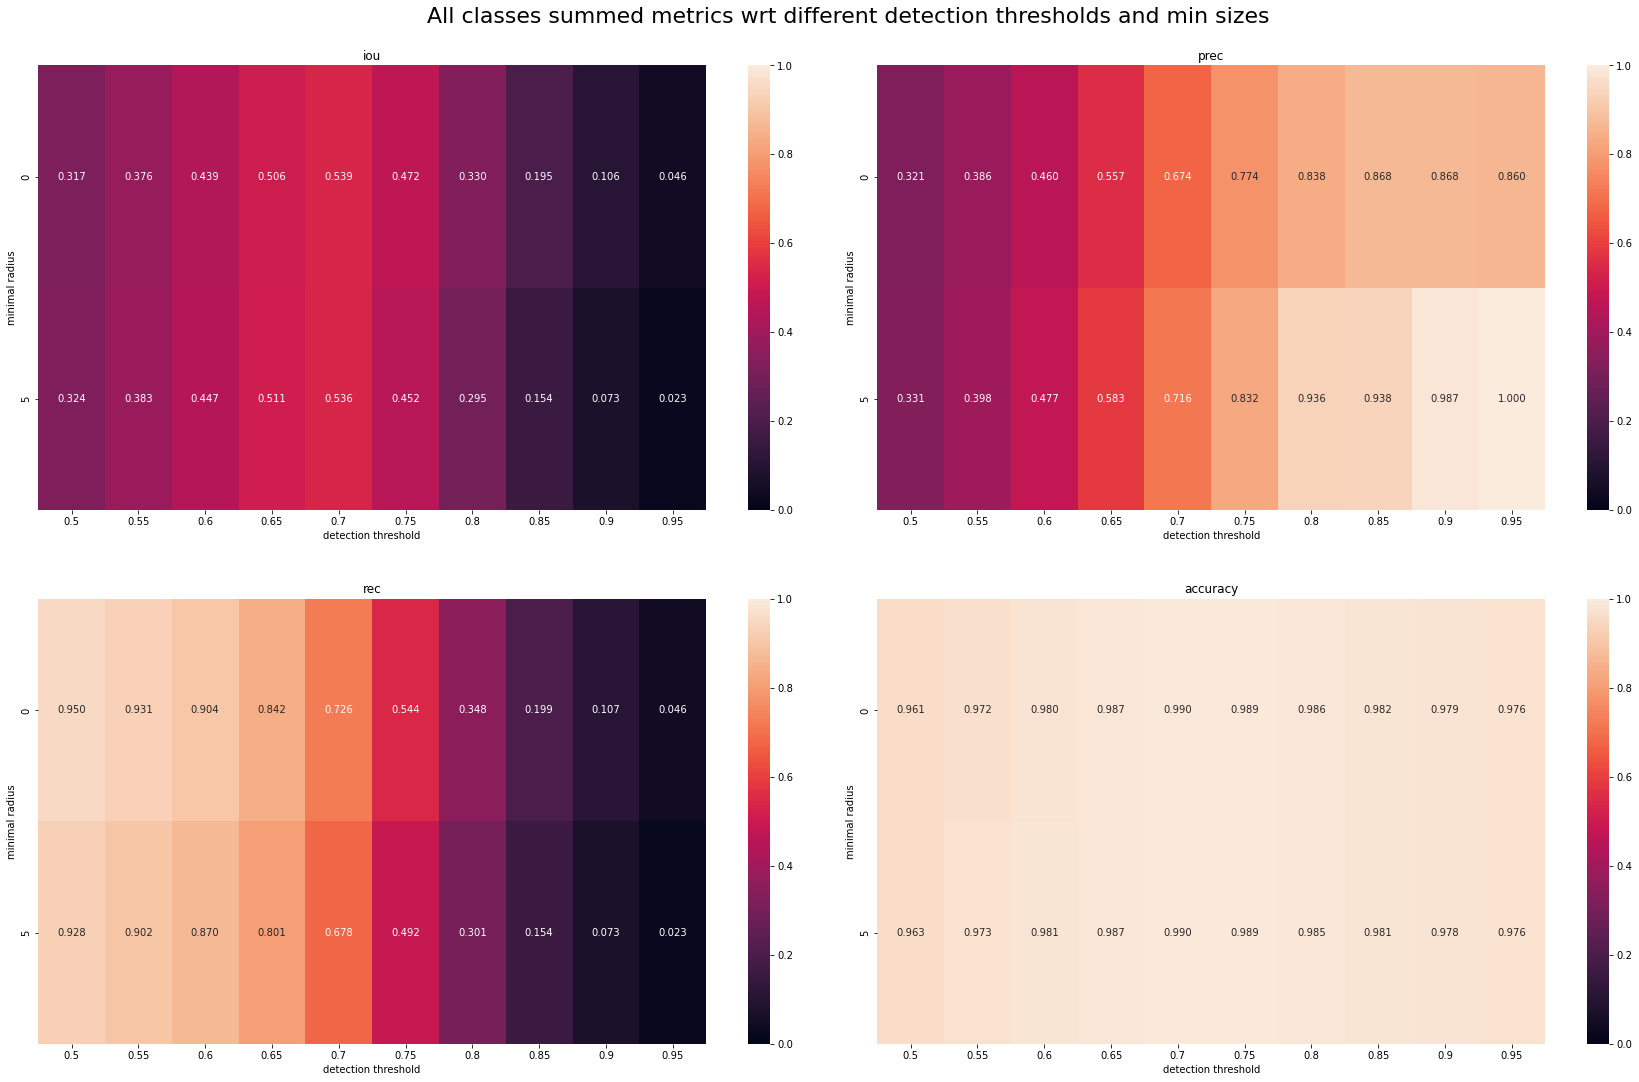

In [25]:
# fix exclusion radius to zero

# get dicts for fixed exclusion radius (metric x t x min_r)
metrics_plot_dict = defaultdict(lambda: defaultdict(dict))
for t, min_r_metrics in metrics_joined_all_classes_average.items():
    for min_r, exclusion_r_metrics in min_r_metrics.items():
        for metric, val in exclusion_r_metrics[exclusion_r].items():
            metrics_plot_dict[metric][round(float(t),2)][min_r] = val
            
# visualise metrics for raw predicted puffs
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30, 18))
plt.subplots_adjust(hspace=0.2, wspace=0.005)
fig.suptitle(f"All classes summed metrics wrt different detection thresholds and min sizes", fontsize=22, y=0.925)

# loop through metrics and axes
for (metric, val_dict), ax in zip(metrics_plot_dict.items(), axs.ravel()):
    # val_dict is detection_t x min_r
    
    # get dataframes
    df = pd.DataFrame.from_dict(val_dict)
    df.to_csv(os.path.join(data_folder,"df_joined_all_classes_average_"+metric+".csv"))
    
    # plot metrics
    ax.set_title(metric)
    sns.heatmap(df, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
    ax.set_xlabel("detection threshold")
    ax.set_ylabel("minimal radius")
    
    #ax.get_legend().remove()

plt.savefig(os.path.join(data_folder,"joined_all_classes_metrics_average_heatmaps.jpg"))
plt.show()

# Precision and recall for sparks
- Considering varying minimal size of events and detection threshold
- Tried applying different threshold when spark is detected on top of a puff
- Trying to best summarise spark metrics, but e.g. area under the curve and precision-recall plot are not possible

## Precision and recall computation
- UNet's output processing:
    - threshold is applied to output
    - remove small object with size < 2 * min_radius * n_dims (can be changed) from raw preds
    - apply nonmaxima suppresion to binary mask to extract sparks centres:
        - apply gaussian filter with `sigma=2` to preds
        - define minimal distance between two events as an ellipsoid with axes `min_dist_t x min_dist_xy x min_dist_xy`
        - apply maximum filter to smooth preds
        - find common locations between smooth preds and "maximum filtered version"
    - empty marginal frames (not used by loss function)
    - if using puff preds: spark preds is summed to puff preds in regions where puff preds are between a range of values
- Precision and recall computation:
    - multiply preds by `ignore_mask`
    - compute nonmaxima suppression of annotations
    - get sparks locations in both annotations and predictions
    - compute correspondences between annotations and preds
        - since max distance in time and space between pred and annotation are different, coords are divided by max distance along that dimension, then the max distance allowed on the new coords is 1
        - compute dist between al pairs of preds and annotations
        - solve linear sum assignment problem
        - compute prec and rec with respect to paired events

Because of the processing of preds and annotations before computing prec and rec, their values are not linear with respect to the detection threshold.

In [26]:
data_folder = os.path.join(metrics_folder, "spark_prec_rec")

In [27]:
# Load dicts

# dict containing all prec rec scores for all sparks for all movies
with open(os.path.join(data_folder, "prec_rec_sparks.json"), 'r') as f:
    prec_rec_sparks = json.load(f) # min_r x video_id x detection_t x [prec, rec, tp, tp_fp, tp_fn]
    
# dict containing all prec rec scores for all sparks averaged over all movies
with open(os.path.join(data_folder, "prec_rec_sparks_average.json"), 'r') as f:
    prec_rec_sparks_average = json.load(f) # min_r x detection_t x [prec, rec, tp, tp_fp, tp_fn]
    
    
# dict containing all prec rec scores for all sparks on top of puffs for all movies
with open(os.path.join(data_folder, "prec_rec_sparks_on_puffs.json"), 'r') as f:
    prec_rec_sparks_on_puffs = json.load(f) # t x min_r x exclusion_r x video_id
    
# dict containing all prec rec scores for all sparks on top of puffs averaged over all movies
with open(os.path.join(data_folder, "prec_rec_sparks_on_puffs_average.json"), 'r') as f:
    prec_rec_sparks_on_puffs_average = json.load(f) # t x min_r x exclusion_r

## Precision and recall using standard threshold

### Get confusion matrix for varying detection threshold and min size

#### Considering average over all movies.

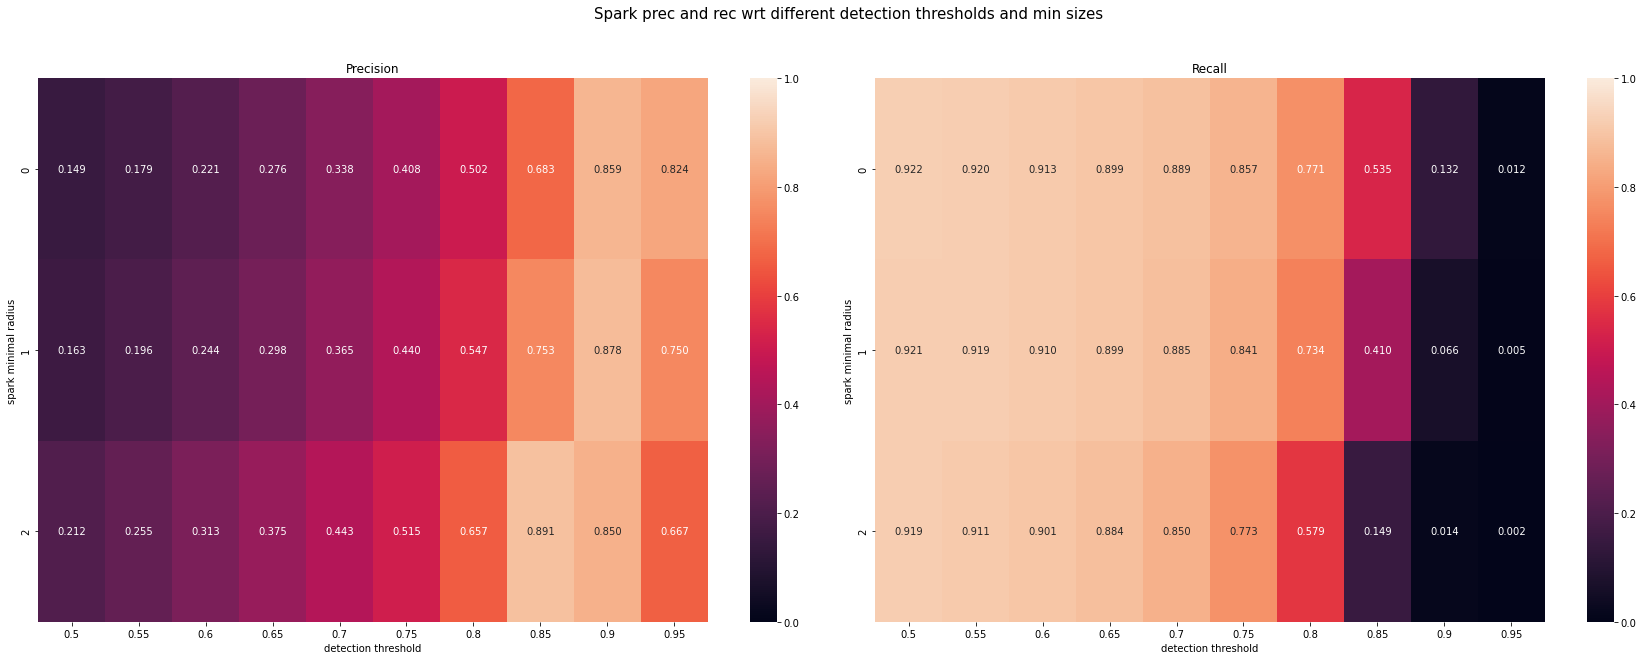

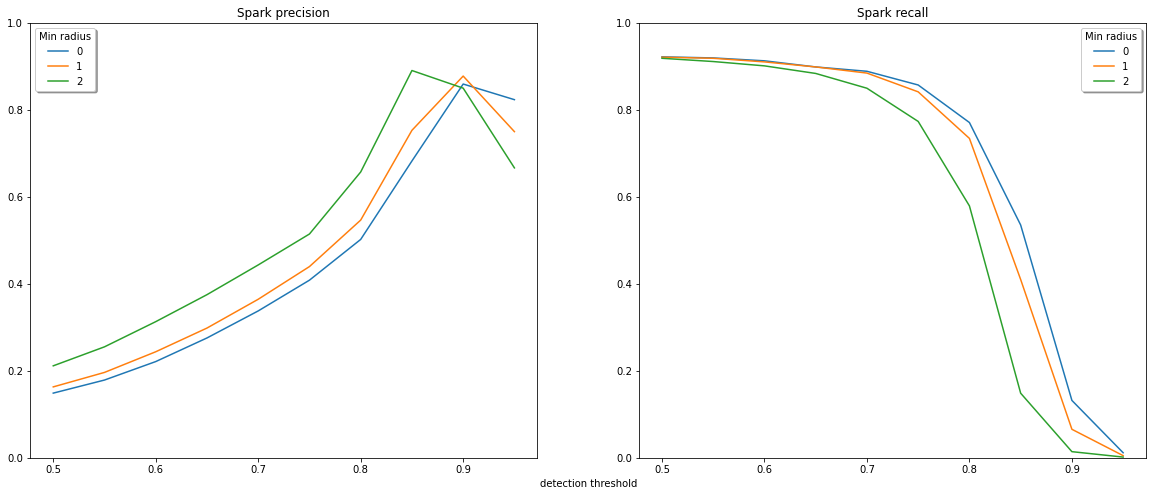

In [28]:
# get dicts for prec and rec
dict_plot_prec = {min_r: {round(float(t),2): metrics[0] for (t, metrics) in t_metrics[0].items()} for (min_r, t_metrics) in prec_rec_sparks_average.items()}
dict_plot_rec = {min_r: {round(float(t),2): metrics[1] for (t, metrics) in t_metrics[0].items()} for (min_r, t_metrics) in prec_rec_sparks_average.items()}

# transpose dicts
dict_cmatrix_prec = defaultdict(lambda: defaultdict(dict))
for min_r, t_metrics in dict_plot_prec.items():
    for t, metrics in t_metrics.items():
        dict_cmatrix_prec[t][min_r] = metrics

dict_cmatrix_rec = defaultdict(lambda: defaultdict(dict))
for min_r, t_metrics in dict_plot_rec.items():
    for t, metrics in t_metrics.items():
        dict_cmatrix_rec[t][min_r] = metrics


# get dataframes
df_prec = pd.DataFrame.from_dict(dict_cmatrix_prec)
df_rec = pd.DataFrame.from_dict(dict_cmatrix_rec)

df_prec.to_csv(os.path.join(data_folder,"df_prec.csv"))
df_rec.to_csv(os.path.join(data_folder,"df_rec.csv"))

plt.figure(figsize=(30, 10))
plt.suptitle(f"Spark prec and rec wrt different detection thresholds and min sizes", fontsize=15)
plt.subplots_adjust(wspace=0.0)

ax = plt.subplot(1,2,1)
ax.set_title("Precision")
sns.heatmap(df_prec, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
ax.set_xlabel("detection threshold")
ax.set_ylabel("spark minimal radius")
ax = plt.subplot(1,2,2)
ax.set_title("Recall")
sns.heatmap(df_rec, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
ax.set_xlabel("detection threshold")
ax.set_ylabel("spark minimal radius")
plt.savefig(os.path.join(data_folder,"prec_rec_avg_heatmaps.jpg"))
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20,8))#, sharex=True)
fig.add_subplot(111, frameon=False)

for min_r in dict_plot_prec.keys():
    prec = dict_plot_prec[min_r]
    axs[0].plot(prec.keys(), prec.values(), label=min_r)
           
axs[0].set_title('Spark precision')
axs[0].set_ylim([0,1])
axs[0].legend(shadow=True, fancybox=True, title="Min radius")

for min_r in dict_plot_rec.keys():
    rec = dict_plot_rec[min_r]
    axs[1].plot(rec.keys(), rec.values(), label=min_r)
           
axs[1].set_title('Spark recall')
axs[1].set_ylim([0,1])
axs[1].legend(shadow=True, fancybox=True, title="Min radius")

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("detection threshold")

fig.savefig(os.path.join(data_folder,"prec_rec_all_movies_excl_radius.jpg"))

#### Sample movie

In [29]:
movie_id = '02'

# get sample metrics
prec_rec_sparks_sample = {min_r : samples_metrics[movie_id] for (min_r, samples_metrics) in prec_rec_sparks.items()}

# get dicts for prec and rec
dict_plot_prec_sample = {min_r: {round(float(t),2): metrics[0] for (t, metrics) in t_metrics.items()} for (min_r, t_metrics) in prec_rec_sparks_sample.items()}
dict_plot_rec_sample = {min_r: {round(float(t),2): metrics[1] for (t, metrics) in t_metrics.items()} for (min_r, t_metrics) in prec_rec_sparks_sample.items()}

# transpose dicts
dict_cmatrix_prec_sample = defaultdict(lambda: defaultdict(dict))
for min_r, t_metrics in dict_plot_prec_sample.items():
    for t, metrics in t_metrics.items():
        dict_cmatrix_prec_sample[t][min_r] = metrics

dict_cmatrix_rec_sample = defaultdict(lambda: defaultdict(dict))
for min_r, t_metrics in dict_plot_rec_sample.items():
    for t, metrics in t_metrics.items():
        dict_cmatrix_rec_sample[t][min_r] = metrics


# get dataframes
df_prec = pd.DataFrame.from_dict(dict_cmatrix_prec_sample)
df_rec = pd.DataFrame.from_dict(dict_cmatrix_rec_sample)

print("Sample:", movie_id)
print("PRECISION")
display(df_prec)
print("RECALL")
display(df_rec)

Sample: 02
PRECISION


,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
0,0.097561,0.129032,0.173913,0.212121,0.304348,0.411765,0.700000,0.857143,1.0,1.0
1,0.111111,0.150943,0.205128,0.225806,0.318182,0.538462,0.700000,0.833333,1.0,1.0
2,0.166667,0.179487,0.225806,0.318182,0.500000,0.700000,0.833333,1.000000,1.0,1.0


RECALL


,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95
0,1.0,1.000,1.000,0.875,0.875,0.875,0.875,0.750,0.500,0.250
1,1.0,1.000,1.000,0.875,0.875,0.875,0.875,0.625,0.500,0.125
2,1.0,0.875,0.875,0.875,0.875,0.875,0.625,0.500,0.125,0.000


## Compute and plot F1 score

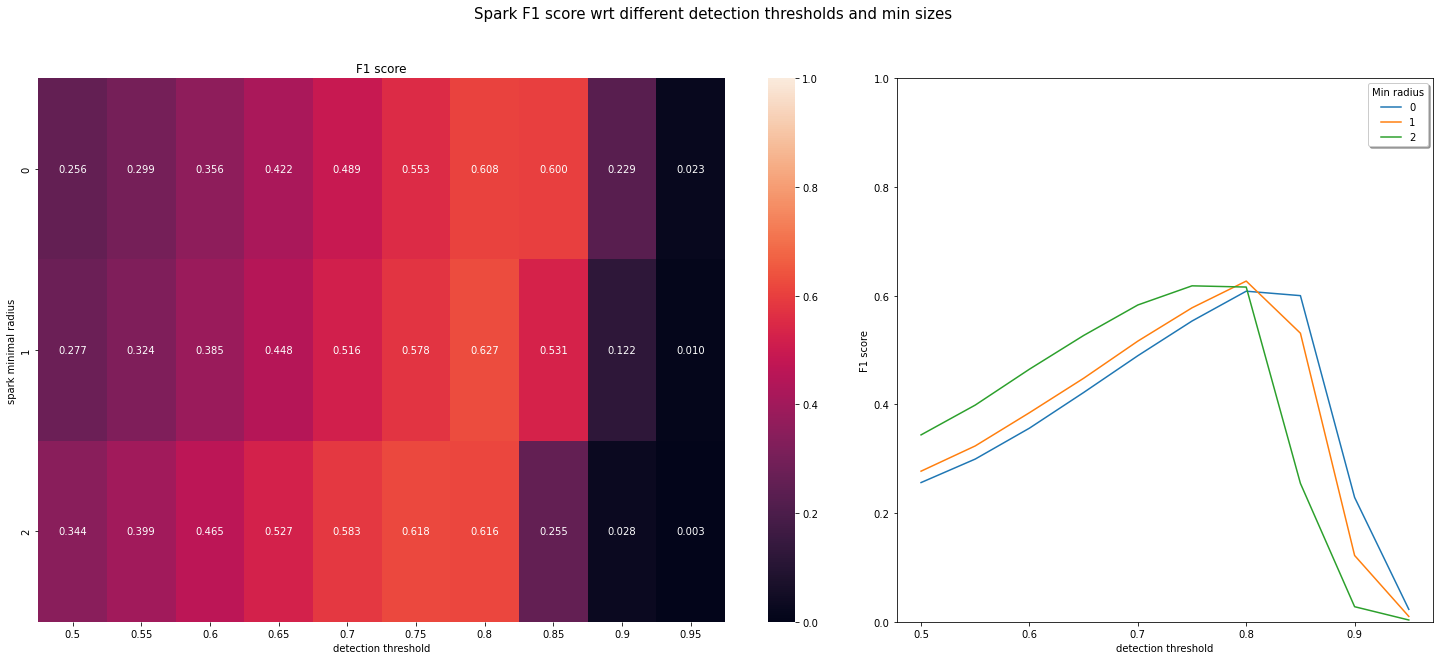

In [30]:
f1_dict = {min_r: {round(float(t),2): compute_f_score(metrics[0],metrics[1]) for t,metrics in prec_rec_t[0].items()} for min_r,prec_rec_t in prec_rec_sparks_average.items()}
# min_radius x detection_t

# get dataframes
df_f1_score = pd.DataFrame.from_dict(f1_dict).T
df_f1_score.to_csv(os.path.join(data_folder,"df_f1.csv"))

# plot figures
fig = plt.figure(figsize=(25, 10))
plt.suptitle(f"Spark F1 score wrt different detection thresholds and min sizes", fontsize=15)
plt.subplots_adjust(wspace=0.0)
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 1]) 

ax = plt.subplot(gs[0])
ax.set_title("F1 score")
sns.heatmap(df_f1_score, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
ax.set_xlabel("detection threshold")
ax.set_ylabel("spark minimal radius")

ax = plt.subplot(gs[1])
for min_r, f1_scores in f1_dict.items():
    ax.plot(f1_scores.keys(), f1_scores.values(), label=min_r)
    
ax.set_xlabel("detection threshold")
ax.set_ylabel("F1 score")
ax.legend(shadow=True, fancybox=True, title="Min radius")
ax.set_ylim([0,1])
plt.savefig(os.path.join(data_folder,"f1_score_avg_heatmaps_and_plot.jpg"))
plt.show()

## Plot metrics (precision, recall, F1 scores) for each movie, with min_radius=0

In [39]:
min_r_sparks = '0'

In [34]:
'''# rename metrics_puffs and metrics_puffs_average keys !!
for old_key in metrics_puffs.fromkeys(metrics_puffs):
    new_key = old_key[:4]
    metrics_puffs[new_key] = metrics_puffs.pop(old_key)
    metrics_puffs_average[new_key] = metrics_puffs_average.pop(old_key)''';

In [36]:
# get dicts for single movies
dict_single_movie_plot = defaultdict(lambda: defaultdict(dict)) # detection t x video name x metric 
for movie_name, movie_metrics in prec_rec_sparks[min_r_sparks].items():
    for t, metrics in movie_metrics.items():
        dict_single_movie_plot['prec'][round(float(t),2)][movie_name] = metrics[0]
        dict_single_movie_plot['rec'][round(float(t),2)][movie_name] = metrics[1]
        dict_single_movie_plot['f1_score'][round(float(t),2)][movie_name] = compute_f_score(metrics[0], metrics[1])

In [37]:
for t, metrics in prec_rec_sparks_average[min_r_sparks][0].items():
    dict_single_movie_plot['prec'][round(float(t),2)]['AVERAGE'] = metrics[0]
    dict_single_movie_plot['rec'][round(float(t),2)]['AVERAGE'] = metrics[1]
    dict_single_movie_plot['f1_score'][round(float(t),2)]['AVERAGE'] = compute_f_score(metrics[0], metrics[1])

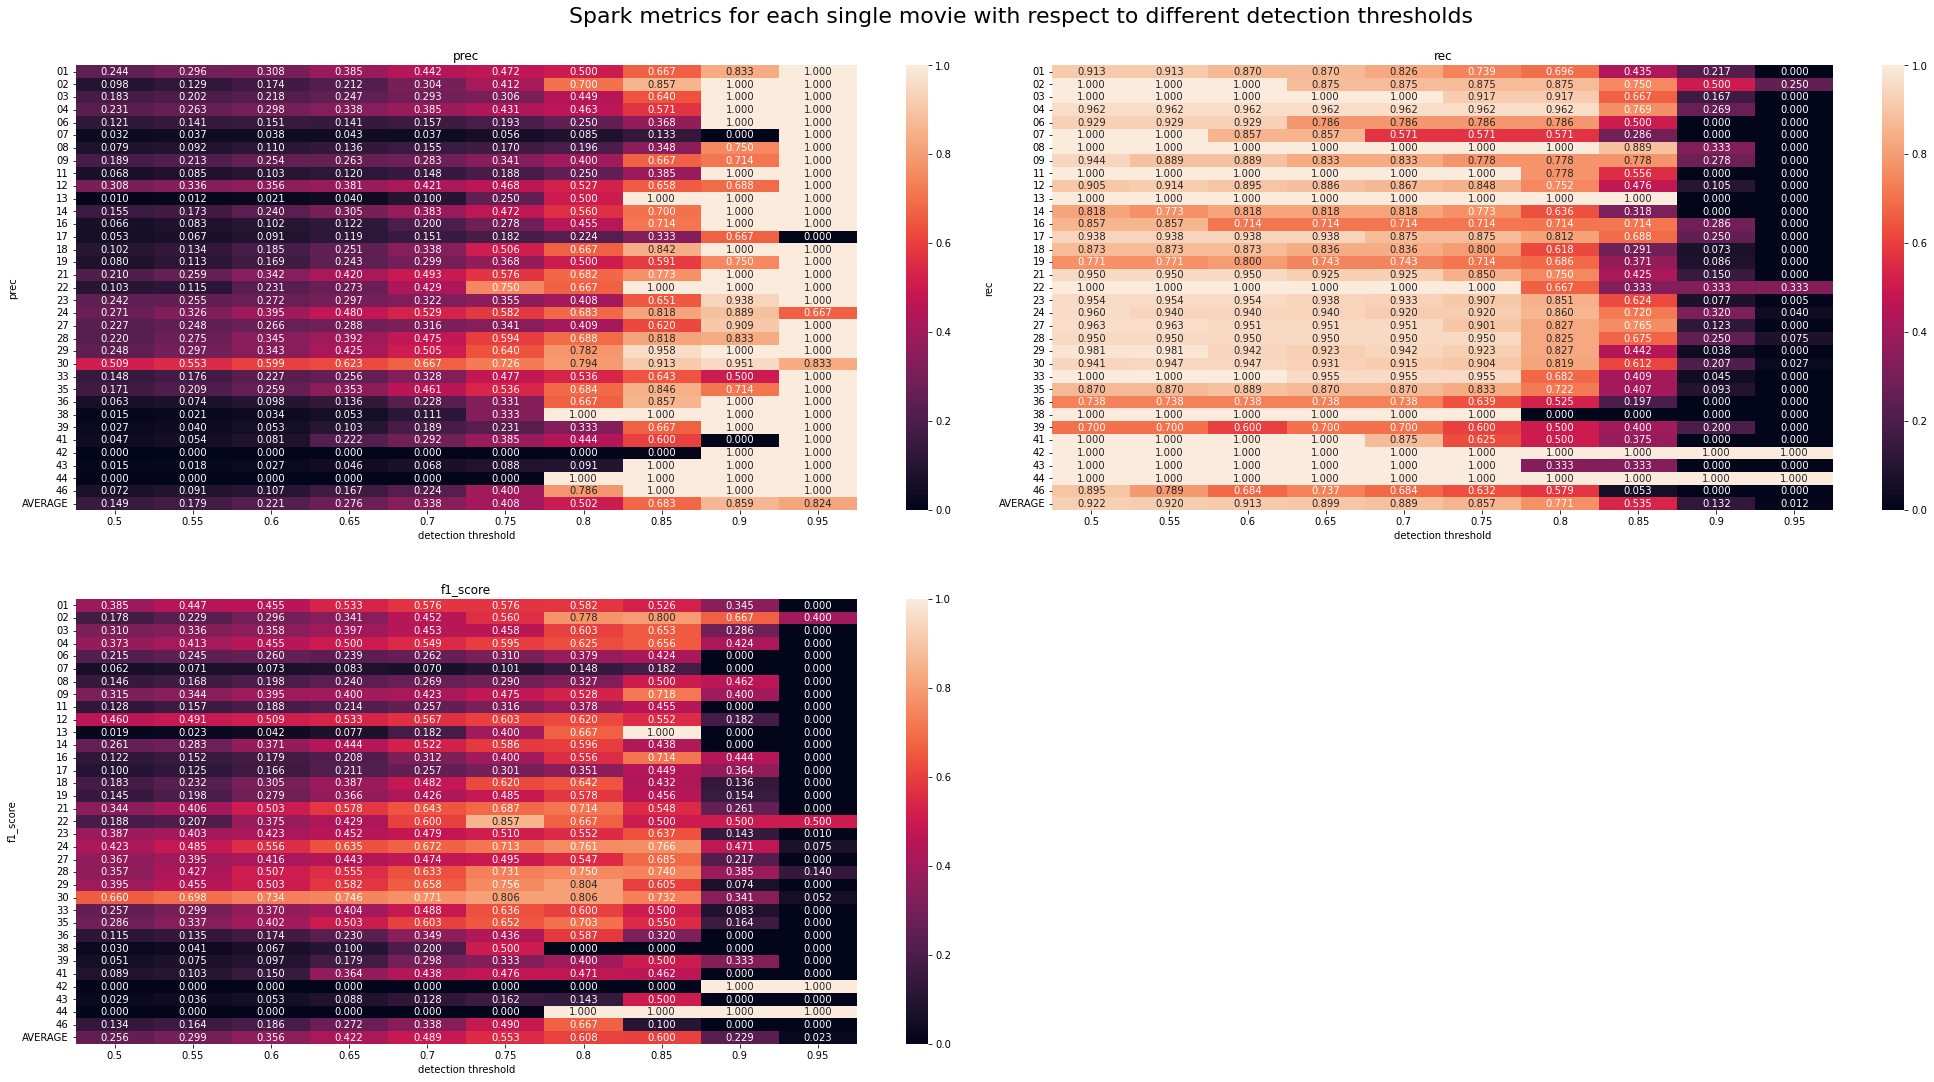

In [38]:
# visualise metrics with respect to detection threshold
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(35, 18))
plt.subplots_adjust(hspace=0.2, wspace=0.)
fig.suptitle(f"Spark metrics for each single movie with respect to different detection thresholds", fontsize=22, y=0.925)

# loop through metrics and axes
for (metric, val_dict), ax in zip(dict_single_movie_plot.items(), axs.ravel()):
    # val_dict is detection_t x movie_name
    
    # get dataframes
    df = pd.DataFrame.from_dict(val_dict)
    
    # plot metrics
    ax.set_title(metric)
    sns.heatmap(df, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
    ax.set_xlabel("detection threshold")
    ax.set_ylabel(metric)

fig.delaxes(axs[1][1])
plt.savefig(os.path.join(data_folder,"spark_metrics_single_movies_heatmaps.jpg"))
plt.show()

## Precision and recall using different threshold on top of puffs -> NOT WORTH IT

Many sparks are not detected because they are in the middle (i.e. on top) of puffs.
- the probability of the sparks class is lower 
- this results in "holes" in the prediction of puffs

### Get confusion matrix for varying detection threshold and upper detection threshold for puffs

#### Considering average over all movies.

Setting `min_radius = 1` temporarily.

PRECISION


,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
0.0,0.001052,0.009316,0.016629,0.025863,0.036466,0.047166,0.060136,0.072165,0.084298,0.097040,...,0.135269,0.159230,0.192308,0.233983,0.285981,0.378205,0.583333,0.722222,1.000000,1.0
0.5,0.001052,0.008025,0.012757,0.018004,0.022655,0.025896,0.028788,0.034328,0.037673,0.039849,...,0.119757,0.144231,0.172570,0.206243,0.240929,0.285088,0.312775,0.222222,0.207792,1.0
0.55,0.001052,0.008257,0.013181,0.018772,0.024062,0.027341,0.030564,0.036546,0.041367,0.044161,...,0.102484,0.140925,0.167244,0.196859,0.228142,0.269618,0.276364,0.182857,0.188119,1.0
0.6,0.001052,0.008224,0.013299,0.019114,0.024431,0.028034,0.031478,0.037252,0.043725,0.049322,...,0.060213,0.125704,0.165122,0.193516,0.221929,0.258364,0.258170,0.179104,0.182540,1.0
0.65,0.001052,0.008336,0.013344,0.019267,0.024785,0.028201,0.031820,0.038178,0.046313,0.053386,...,0.068304,0.075149,0.151698,0.190338,0.218710,0.254355,0.248521,0.184211,0.189189,1.0


RECALL


,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
0.0,0.697318,0.804598,0.808429,0.812261,0.816092,0.816092,0.816092,0.804598,0.781609,0.766284,...,0.731801,0.697318,0.670498,0.643678,0.586207,0.452107,0.214559,0.049808,0.003831,0.0
0.5,0.697318,0.773946,0.766284,0.781609,0.793103,0.789272,0.785441,0.789272,0.781609,0.770115,...,0.754789,0.747126,0.727969,0.708812,0.636015,0.498084,0.272031,0.114943,0.061303,0.0
0.55,0.697318,0.785441,0.773946,0.789272,0.808429,0.793103,0.789272,0.781609,0.770115,0.754789,...,0.758621,0.758621,0.739464,0.720307,0.639847,0.513410,0.291188,0.122605,0.072797,0.0
0.6,0.697318,0.773946,0.766284,0.781609,0.793103,0.781609,0.777778,0.762452,0.766284,0.766284,...,0.781609,0.770115,0.750958,0.731801,0.643678,0.532567,0.302682,0.137931,0.088123,0.0
0.65,0.697318,0.777778,0.758621,0.773946,0.785441,0.766284,0.762452,0.754789,0.770115,0.770115,...,0.777778,0.773946,0.770115,0.754789,0.662835,0.559387,0.321839,0.160920,0.107280,0.0


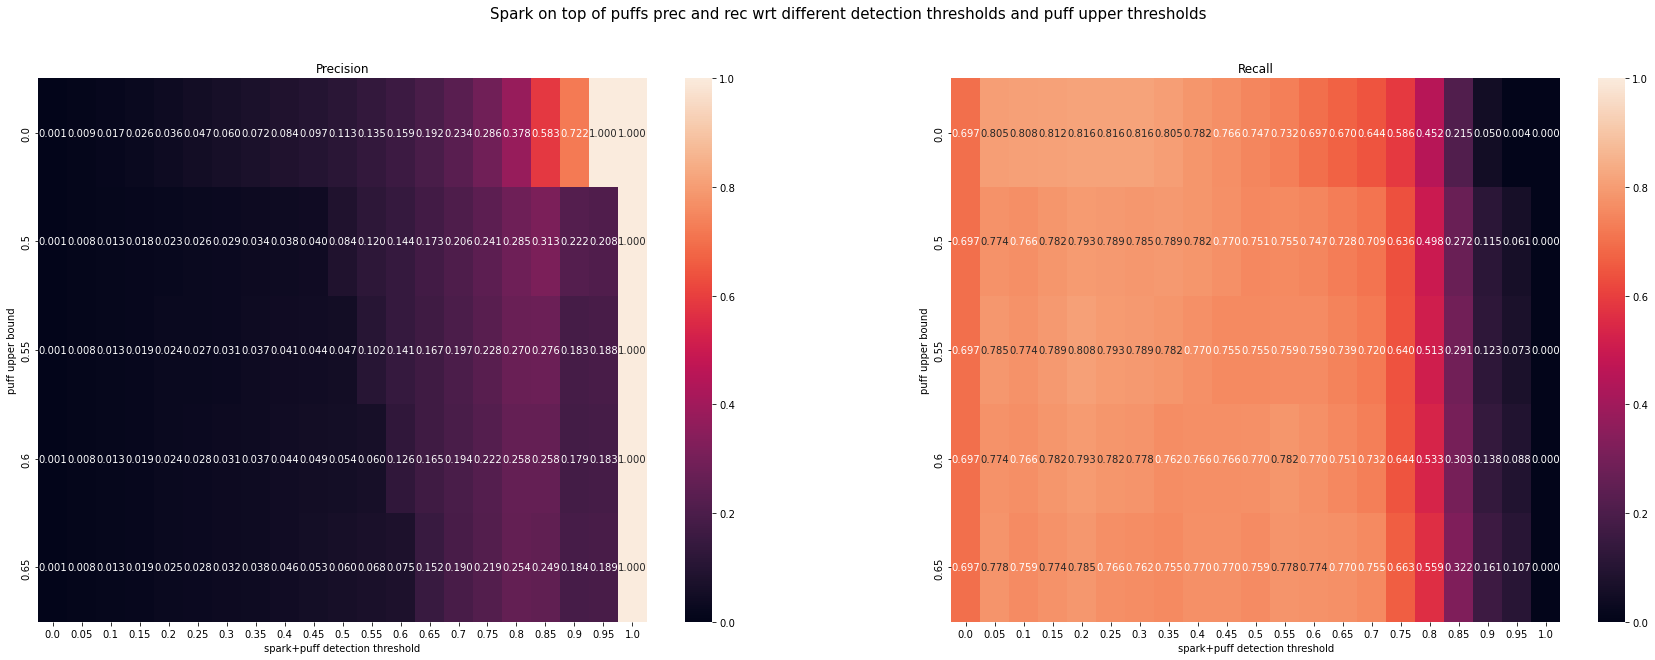

In [34]:
min_r = '1'
# get dicts for prec and rec
dict_plot_prec_puffs = {t_puff: {round(float(t_spark),2): metrics[0] for (t_spark, metrics) in t_metrics[0].items()} for (t_puff, t_metrics) in prec_rec_sparks_on_puffs_average[min_r].items()}
dict_plot_rec_puffs =  {t_puff: {round(float(t_spark),2): metrics[1] for (t_spark, metrics) in t_metrics[0].items()} for (t_puff, t_metrics) in prec_rec_sparks_on_puffs_average[min_r].items()}

# transpose dicts
dict_cmatrix_prec_puffs = defaultdict(lambda: defaultdict(dict))
for t_puff, t_metrics in dict_plot_prec_puffs.items():
    for t_spark, metrics in t_metrics.items():
        dict_cmatrix_prec_puffs[t_spark][t_puff] = metrics

dict_cmatrix_rec_puffs = defaultdict(lambda: defaultdict(dict))
for t_puff, t_metrics in dict_plot_rec_puffs.items():
    for t_spark, metrics in t_metrics.items():
        dict_cmatrix_rec_puffs[t_spark][t_puff] = metrics


# get dataframes
df_prec_puffs = pd.DataFrame.from_dict(dict_cmatrix_prec_puffs)
df_rec_puffs = pd.DataFrame.from_dict(dict_cmatrix_rec_puffs)

print("PRECISION")
display(df_prec_puffs)
print("RECALL")
display(df_rec_puffs)

plt.figure(figsize=(30, 10))
plt.suptitle(f"Spark on top of puffs prec and rec wrt different detection thresholds and puff upper thresholds", fontsize=15)

ax = plt.subplot(1,2,1)
ax.set_title("Precision")
sns.heatmap(df_prec_puffs, annot=True, fmt='.3f', vmin=0, vmax=1)
ax.set_xlabel("spark+puff detection threshold")
ax.set_ylabel("puff upper bound")
ax = plt.subplot(1,2,2)
ax.set_title("Recall")
sns.heatmap(df_rec_puffs, annot=True, fmt='.3f', vmin=0, vmax=1)
ax.set_xlabel("spark+puff detection threshold")
ax.set_ylabel("puff upper bound")
plt.savefig(os.path.join(data_folder,"prec_rec_avg_puffs_heatmaps.jpg"))
plt.show()

Remark: many "false positive" are real sparks that haven't been annotated (**see movie with coloured sparks**)

## Compute and plot F1 score

In [35]:
min_r = '0' # fix min radius to 0
f1_dict = {t_puff: {round(float(t_spark),2): compute_f_score(metrics[0],metrics[1]) for t_spark,metrics in prec_rec_t[0].items()} for t_puff,prec_rec_t in prec_rec_sparks_on_puffs_average[min_r].items()}
# puffs_upper_t x detection_t

In [36]:
# get dataframes
df_f1_score = pd.DataFrame.from_dict(f1_dict).T

In [37]:
df_f1_score.to_csv(os.path.join(data_folder,"df_f1_on_puffs.csv"))

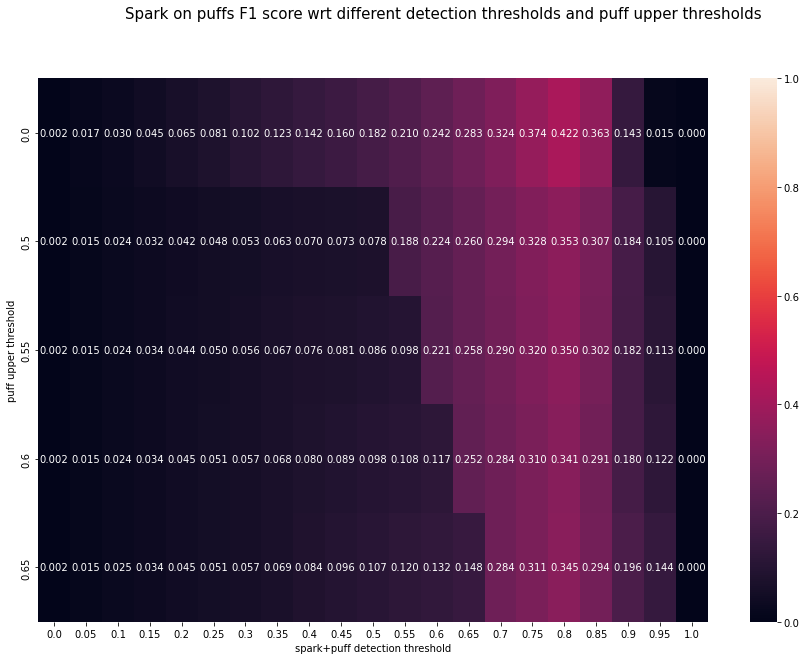

In [38]:
# plot figures
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(df_f1_score, annot=True, fmt='.3f', vmin=0, vmax=1, ax=ax)
plt.suptitle(f"Spark on puffs F1 score wrt different detection thresholds and puff upper thresholds", fontsize=15)

ax.set_ylabel("puff upper threshold")
ax.set_xlabel("spark+puff detection threshold")

plt.savefig(os.path.join(data_folder,"f1_score_avg_heatmaps_and_plot.jpg"))
plt.show()

# Other types of evaluation...
- quantitative evaluation of the method is not very representative of the quality of the predictions
- sometimes "wrongly" predicted events are judged correct by experts because of the high incertitude of the data
- a lot of the "false positive" spark predictions, are actually true events
    - manual threshold has been applied during annotation process, each movie has a different threshold
    - remark: in the UNet output, sparks close to waves are poorly detected (why?)
- since the movies come from different distributions (e.g. different pharmacology), different thresholds would be better suitable for each sample

### Ideas of predictions evalution methods
- creating an interface for experts such that:
    - it presents segmentation with identified events done by UNet and experts annotate them
    - it presents classified segmentation done by UNet and experts decide if events are correct/wrong/grey zone
- Miguel creates first "scarcely" processed segmentation masks for new not annotated samples:
    - experts process and annotate them
    - UNet output is compared with experts' annotated masks

# Manuscript

### Bern Data Science day
- already presented project last year
- new poster focusing on data processing and predictions evaluation?

### Working Group on Cardiac Cellular Electrophysiology Conference
- deadline for abstract on 1st of April

## Other remarks...
- train network to denoise samples? (tried with UNet + MSE)
- temporal reduction improved slightly the results, but I haven't implemented "output expansion" (by number of channels)
- with longer chunks the detection of sparks get worse